# OpenAPS Data Exploration - COB
This exploration is based on the provided dataset (from Isabella Dagens) or a 15min resample of the data, with mean, min/max count and standard deviation over the 15min interval. There is no code in the insulin_need project that carries out this resampling, so this is something that will be built into the project. This notebook is based on a sample dataset of 116 individuals, which is smaller than the latest dataset which numbers 133 unique individuals.

## Initiate Exploration

### Initial loading of libraries and dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.widgets import Slider, Button # pip install ipympl is required for interactive elements
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
from scipy.stats import ttest_ind
import ipympl
# from helperfuncs import *
from src.config import INTERIM_DATA_DIR

%matplotlib ipympl

file_name = '15min_iob_cob_bg_old_sample.csv'


2025-06-09 15:16:21.079 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: C:\Users\ross\OneDrive\Documents\Masters\Project\masters_project


In [3]:
# Used to create parquet file from CSV
dtypes = {
    'system': 'category',
    'iob count': 'Int64',
    'cob count': 'Int64',
    'bg count': 'Int64',
}
df = pd.read_csv(INTERIM_DATA_DIR / file_name, parse_dates=['datetime'], dtype=dtypes)
df = df.drop(columns=['Unnamed: 0']).set_index(['id','datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 599360 entries, (np.int64(90398368), Timestamp('2019-05-21 19:30:00+0000', tz='UTC')) to (np.int64(99908129), Timestamp('2018-02-01 04:45:00+0000', tz='UTC'))
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   system     599360 non-null  category
 1   iob mean   583712 non-null  float64 
 2   cob mean   559344 non-null  float64 
 3   bg mean    599360 non-null  float64 
 4   iob min    583712 non-null  float64 
 5   cob min    559344 non-null  float64 
 6   bg min     599360 non-null  float64 
 7   iob max    583712 non-null  float64 
 8   cob max    559344 non-null  float64 
 9   bg max     599360 non-null  float64 
 10  iob std    290818 non-null  float64 
 11  cob std    281884 non-null  float64 
 12  bg std     297913 non-null  float64 
 13  iob count  599360 non-null  Int64   
 14  cob count  599360 non-null  Int64   
 15  bg count   599360 non-null  Int64   
dt

### Summarise Dataset

Number of records: 599360
Number of people: 116
Systems used: ['OpenAPS']
Categories (1, object): ['OpenAPS']


Aggregated descriptive information, by individual:


min_date                  max_date  iob_count  \
id                                                                       
221634  2018-03-16 20:30:00+00:00 2018-07-18 21:30:00+00:00       2918   
309157  2019-02-01 13:30:00+00:00 2019-08-24 22:45:00+00:00         63   
897741  2017-02-03 06:15:00+00:00 2018-01-31 23:45:00+00:00       3404   
1352464 2016-05-16 12:45:00+00:00 2018-01-02 23:45:00+00:00       7532   
2033176 2019-06-19 12:30:00+00:00 2019-08-02 03:15:00+00:00        153   

         cob_count  bg_count   day_range  
id                                        
221634        2918      2918  124.041667  
309157          63        63  204.385417  
897741        3403      3404  362.729167  
1352464       5833      8623  596.458333  
2033176        153       153   43.614583

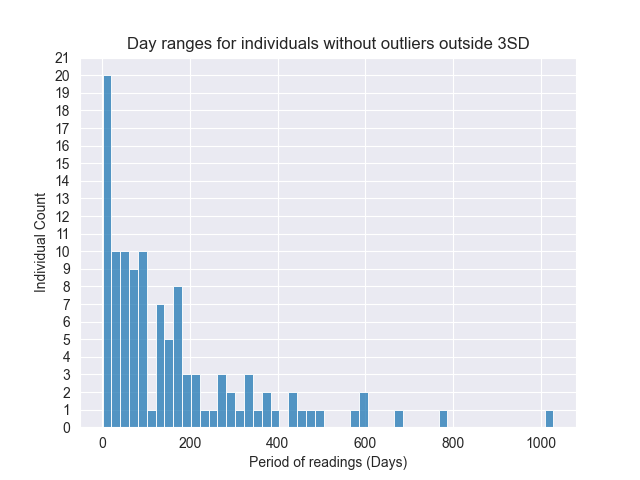

In [4]:
df = df.reset_index()
print(f'Number of records: {len(df)}')
print(f"Number of people: {len(df['id'].drop_duplicates())}")
print(f"Systems used: {df['system'].drop_duplicates().values}")

# Check for people with no COB data
df = df[~df['id'].isin(df.groupby('id').agg({'cob max': 'sum'}).query("`cob max` == 0").index.values)]

dfagg = df.groupby('id', observed=False).agg(
    min_date = ('datetime', 'min'),
    max_date = ('datetime', 'max'),
    iob_count = ('iob mean', 'count'),
    cob_count = ('cob mean', 'count'),
    bg_count = ('bg mean', 'count')
    ).sort_values('id')
dfagg['day_range'] = (dfagg['max_date'] - dfagg['min_date']) / np.timedelta64(1,'D')
print("\n")
print("Aggregated descriptive information, by individual:")
display(dfagg.head(5))

z_scores = stats.zscore(dfagg['day_range'])
day_range_no_outliers = dfagg[(z_scores > -3) & (z_scores < 3)]
sns.histplot(day_range_no_outliers['day_range'], binwidth=20)
plt.title('Day ranges for individuals without outliers outside 3SD')
plt.ylabel('Individual Count')
plt.xlabel('Period of readings (Days)')
plt.yticks(range(0,22,1))
plt.show()

In [5]:
df[~df['id'].isin(df.groupby('id').agg({'cob max': 'sum'}).query("`cob max` == 0").index.values)].head(5)

id                  datetime   system  iob mean  cob mean  bg mean  \
0  90398368 2019-05-21 19:30:00+00:00  OpenAPS       NaN       NaN     48.0   
1  90398368 2019-05-21 20:15:00+00:00  OpenAPS       NaN       NaN    128.0   
2  90398368 2019-05-21 20:30:00+00:00  OpenAPS       NaN       NaN    134.0   
3  90398368 2019-05-21 20:45:00+00:00  OpenAPS       NaN       NaN    140.0   
4  90398368 2019-05-21 21:00:00+00:00  OpenAPS       NaN       NaN    154.0   

   iob min  cob min  bg min  iob max  cob max  bg max  iob std  cob std  \
0      NaN      NaN    48.0      NaN      NaN    48.0      NaN      NaN   
1      NaN      NaN   128.0      NaN      NaN   128.0      NaN      NaN   
2      NaN      NaN   134.0      NaN      NaN   134.0      NaN      NaN   
3      NaN      NaN   140.0      NaN      NaN   140.0      NaN      NaN   
4      NaN      NaN   154.0      NaN      NaN   154.0      NaN      NaN   

   bg std  iob count  cob count  bg count  
0     NaN          0          0         1  
1     NaN          0          0         1  
2     NaN          0          0         1  
3     NaN          0          0         1  
4     NaN          0          0         1

## Data Quality Analysis
### Single Indiviual's Record

In [6]:
id = 90398368

display(dfagg.loc[id])

def cob_individual(df, id):
    if id not in df['id'].values:
        raise ValueError(f"Individual {id} not found in dataset")
    dfindiv = df[df['id']==id]
    df_cob = (dfindiv[['id','datetime','cob max']].
              set_index(['id','datetime']))
    df_cob['day'] = df_cob.index.get_level_values('datetime').date
    return df_cob

df_cob = cob_individual(df, id)
df_cob.head(5)

min_date     2019-05-21 19:30:00+00:00
max_date     2019-05-29 14:45:00+00:00
iob_count                          226
cob_count                          226
bg_count                           232
day_range                     7.802083
Name: 90398368, dtype: object

cob max         day
id       datetime                                      
90398368 2019-05-21 19:30:00+00:00      NaN  2019-05-21
         2019-05-21 20:15:00+00:00      NaN  2019-05-21
         2019-05-21 20:30:00+00:00      NaN  2019-05-21
         2019-05-21 20:45:00+00:00      NaN  2019-05-21
         2019-05-21 21:00:00+00:00      NaN  2019-05-21

Initial findings show that IOB, COB and BG won't necessarily have the same amount of values. When we focus on COB more deeply, we'll investigate the prevalence of missing values. We see above for COB that not only are there NaNs, there are periods of missing samples (e.g. where - for id=90398368, sample times jump from 2019-05-29 11:15:00+00:00 to 2019-05-29 13:30:00+00:00, when the interval should be every 15 minutes).

### Identiying peaks of COB in the data
COB is measured in grammes. 'cob max' is the chosen random variable from the options of min/max/mean given that our principle aim is to identify peaks in the data. The maximum for a given timeframe will find the peak of the readings for each sample. The plot of someone's CoB shows a range of well-defined peaks, as we would expect. We need a way to identify those peaks and the maximum value, so that we may use them (and their relevant timestamps) to understand when someone has taken a meal. There are many methods that carry out this function but not all will necessarily be optimal for our data. In this example, we see well defined peaks, generally going from zero to the peak immediately, though in some cases secondary or tertiary peaks. Also, given we are only interested in peaks rather than troughs, this may have an impact on the algorithm design. We need to find the peaks, for which SciPy has a used function in their API:

SciPy API - Signal Processing - scipy.signal.find_peaks

find_peaks(x, height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

Video description: https://youtu.be/75mdKyA76i8?si=Z8I04LLQ-dDQm0VD


The following allows us to calculate the peaks given certain parameters and plot those peaks to visualise them in the time series.

In [7]:
def cob_peaks(ser: pd.Series, h: int = 1, d: int = None, p: int = None):
    ser.fillna(0)
    peak_indices, properties = find_peaks(ser, height=h, distance=d, prominence=p)
    return peak_indices, properties

def plot_peaks(df: pd.DataFrame, peak_indices: np.array, y: str = 'cob max',  title: str = 'COB Peaks'):
    fig, ax = plt.subplots(figsize=(16,4))
    sns.lineplot(data=df, x=df.index.get_level_values('datetime'), y=y, ax=ax, estimator=None)
    df['hue'] = 1
    df_peaks = df.iloc[peak_indices]
    sns.scatterplot(data=df_peaks, x=df_peaks.index.get_level_values('datetime'), y=y, hue='hue', palette='Set1', legend=False, ax=ax)
    ax.set_ylabel('Grammes')
    ax.set_xlabel('Date/Time')
    plt.title(title)
    plt.show()

Now using our original subject of 90398368, we calculate and map the data.

Peak incides:
[ 11  21  30  34  39  48  57  59  62  79  90 101 104 115 117 129 131 134
 136 142 161 192 215 225 229]
Peak heights at indices:
[26.073  8.45  13.758  8.664 48.    14.132  2.663 45.595 42.414 43.801
 27.015 30.498 22.993 26.031 43.714 13.33  50.677 44.702 58.702 20.089
 35.    10.568 15.     6.692 13.386]


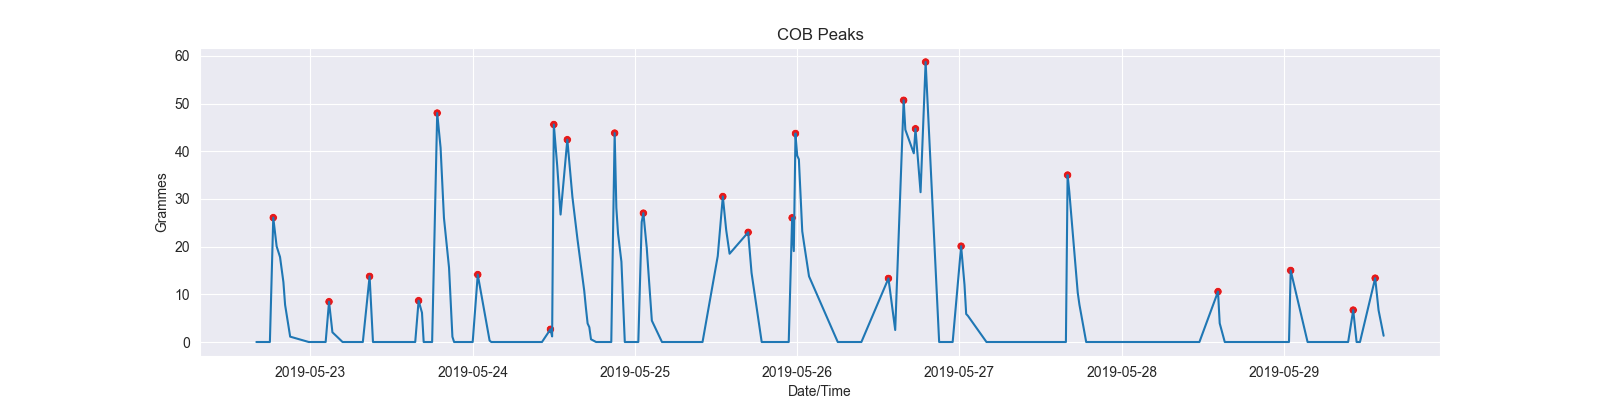

In [8]:
peak_indices, properties = cob_peaks(df_cob['cob max'], h=1)
print('Peak incides:')
print(peak_indices)
print('Peak heights at indices:')
print(properties['peak_heights'])
plot_peaks(df_cob, peak_indices)

### Investigate missing values across entire dataset
To investigate missing values, we'll first build some functions to help with analysing the level of missing data and then drill down into the best way to handle it. Lets first look at what the scope of missing data is across the sample. It is important to build out the data to the full range of interval values which get_time_series_range helps with. We look at two basic imputation approaches, replacing with zero values (as a baseline) and then interpolation. The functions are applied to an individual to give a view of the missing data across their time series, with find_peaks used (with baseline parameters of h=1 and d=1) in order to show how it behaves in each scenario.

In [10]:
def get_time_series_range(df: pd.DataFrame, interval: str):
    min_date = df.index.get_level_values('datetime').min()
    max_date = df.index.get_level_values('datetime').max()
    date_rng = pd.date_range(start=min_date, end=max_date, freq=interval)
    return date_rng

def calc_peaks_for_comparison(df: pd.DataFrame, h: int = 1, d: int = 1):
    df = df.reset_index().set_index('datetime')
    df['cob interpolated'] = df['cob max'].interpolate(method='time')
    df = df.reset_index().set_index(['id','datetime'])
    df['cob zeros'] = df['cob max'].fillna(0)
    peaks_arr,_ = cob_peaks(df['cob max'], h=h, d=d)
    peaks_inter_arr = cob_peaks(df['cob interpolated'], h=h, d=d)
    peaks_zeros_arr = cob_peaks(df['cob zeros'], h=h, d=d)
    return df, peaks_arr, peaks_inter_arr, peaks_zeros_arr

# Produces analysis for an individual's COB data to understand prevelance of missing values using 15-minute intervals
def cob_missing_summary(df: pd.DataFrame, id: int, print_result: bool = True):
    # Calculate basic statistics including missing intervals
    n = len(df)
    nans = df['cob max'].isnull().sum()
    min_date = df.index.get_level_values('datetime').min()  
    max_date = df.index.get_level_values('datetime').max()
    date_rng = get_time_series_range(df, '15min')
    num_intervals = len(date_rng)
    missing_samples = num_intervals - n
    total_missing = nans + missing_samples
    days_in_range = num_intervals / 96

    # Add missing values to dataframe and calculate peaks. calc_peaks_for_comparison returns the dataframe and peak indices for the original, interpolated and zeroed COB values
    index = pd.MultiIndex.from_product([[id], date_rng], names=['id', 'datetime'])
    df = df.reindex(index)
    df['day'] = df.index.get_level_values('datetime').date
    df, peaks_arr, peaks_inter_arr, peaks_zeros_arr = calc_peaks_for_comparison(df)

    # Calculate differences in peaks between original, interpolated and zeroed values
    peaks = len(peaks_arr)
    peaks_interpolated = len(peaks_inter_arr[0])
    peaks_zeros = len(peaks_zeros_arr[0])
    peaks_diff_int = peaks_interpolated - peaks
    peaks_diff_zeros = peaks_zeros - peaks
    if peaks_diff_int != 0 and peaks != 0:
        peaks_change_int = (peaks_diff_int/peaks)*100
    else:
        peaks_change_int = np.nan
    if peaks_diff_zeros != 0 and peaks != 0:
        peaks_change_zeros = (peaks_diff_zeros/peaks)*100
    else:
        peaks_change_zeros = np.nan
    total_pc_missing = (total_missing / num_intervals)*100

    # Calculate number of days with COB data and number of days with missing data
    days_with_data = df.groupby('day').agg({'cob max': 'sum'}).reset_index()
    days_count = len(days_with_data)
    days_missing_data = days_in_range - days_count

    # By default, print the results of the analysis
    if print_result:
        print(f'Start of time series: {min_date}')
        print(f'End of time series: {max_date}')
        print(f'Samples: {n}')
        print(f'NaN values: {nans}')
        print(f'15-minute intervals in range: {num_intervals}')
        print(f'Missing samples: {missing_samples}')
        print(f'Total missing (NaNs and missing): {total_missing}')
        print(f'Days in range: {days_in_range}')
        print(f'Number of COB peaks: {peaks}')
        print(f'Number of interpolated COB peaks: {peaks_interpolated}')
        print(f'Difference in peaks (interpolated values): {peaks_diff_int}')
        print(f'% difference from pre-interpolation: {peaks_change_int}')
        print(f'Difference in peaks (zeroed values): {peaks_diff_zeros}')
        print(f'% difference from pre-zeroing: {peaks_change_zeros}')
        print(f'Total % missing: {total_pc_missing}')
        print(f'Days with COB data: {days_count}')
        print(f'Days with missing data: {days_missing_data}')

    # Return summary as dictionary
    summary = {
        'start': min_date,
        'end': max_date,
        'samples': n,
        'nan_values': nans,
        'intervals': num_intervals,
        'missing_samples': missing_samples,
        'total_missing': total_missing,
        'days': days_in_range,
        'peaks': peaks,
        'peaks_interpolated': peaks_interpolated,
        'peaks_diff_int': peaks_diff_int,
        'peaks_change_int': peaks_change_int,
        'peaks_diff_zeros': peaks_diff_zeros,
        'peaks_change_zeros': peaks_change_zeros,
        'missing_percent': total_pc_missing,
        'days_with_data': days_count,
        'days_missing_data': days_in_range - len(days_with_data)
    }
    return summary


Testing with the same individual as previous.

Start of time series: 2019-05-21 19:30:00+00:00
End of time series: 2019-05-29 14:45:00+00:00
Samples: 232
NaN values: 6
15-minute intervals in range: 750
Missing samples: 518
Total missing (NaNs and missing): 524
Days in range: 7.8125
Number of COB peaks: 3
Number of interpolated COB peaks: 25
Difference in peaks (interpolated values): 22
% difference from pre-interpolation: 733.3333333333333
Difference in peaks (zeroed values): 50
% difference from pre-zeroing: 1666.6666666666667
Total % missing: 69.86666666666666
Days with COB data: 9
Days with missing data: -1.1875


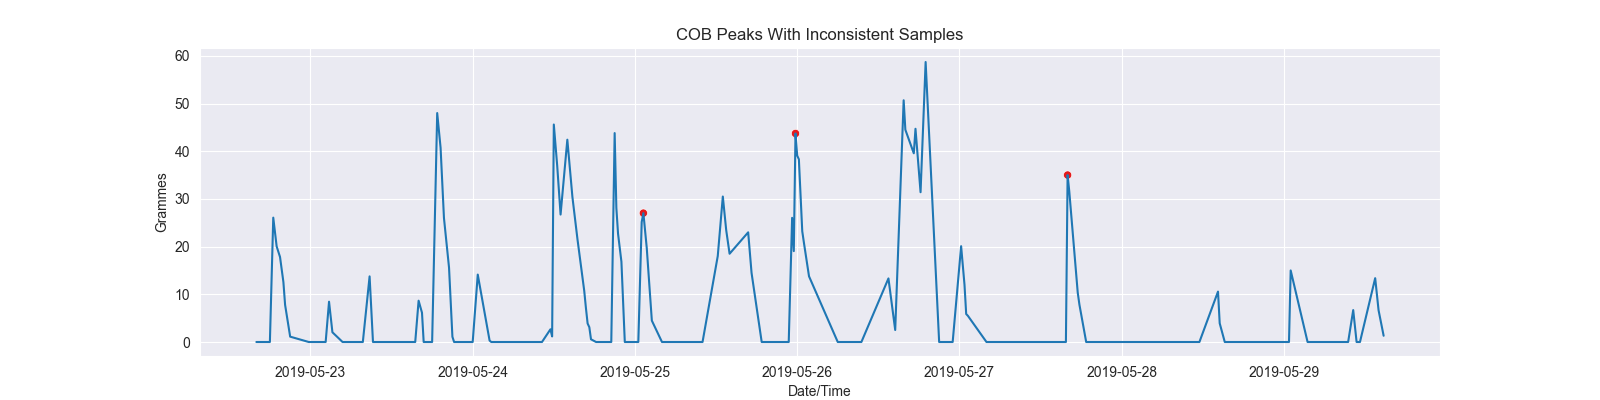

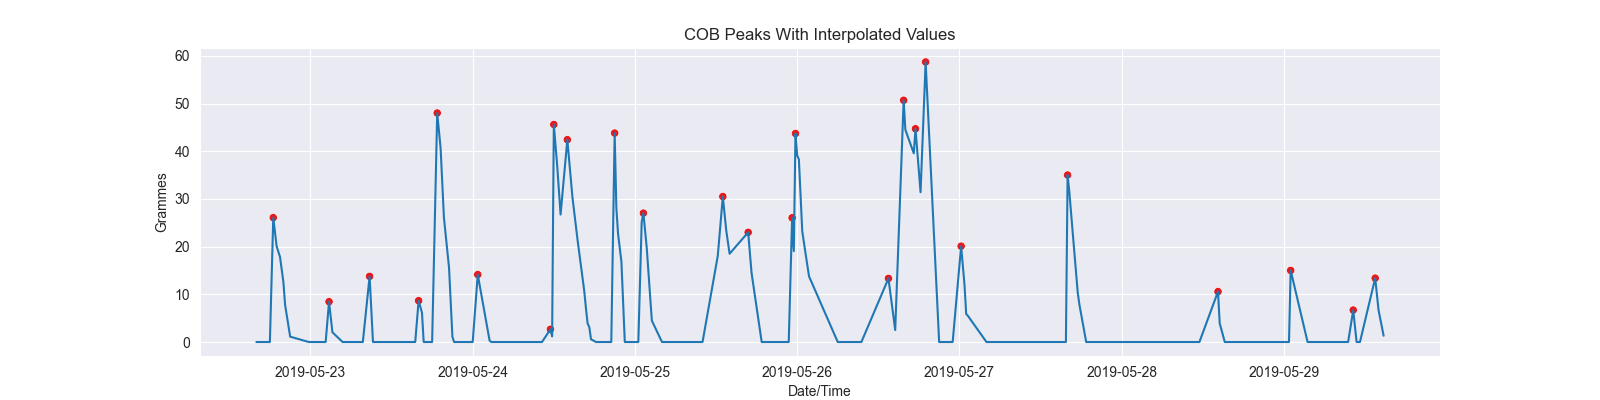

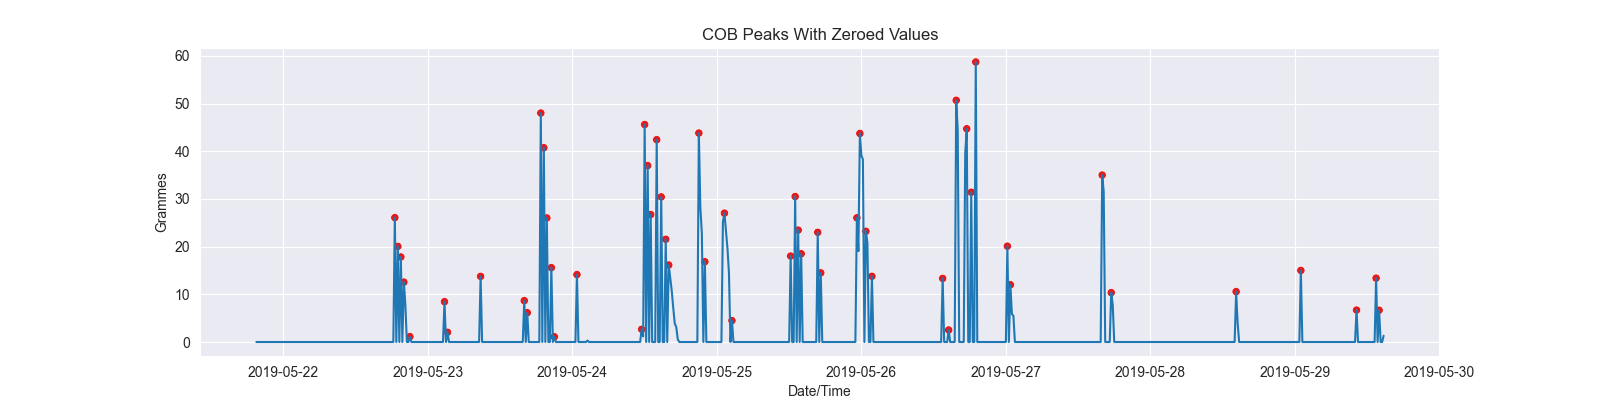

In [11]:
# Pre-process data
id = 90398368
df_cob = cob_individual(df, id)
peak_indices, properties = cob_peaks(df_cob['cob max'], h=1)

# Display results
cob_missing_summary(df_cob, id)
dr = get_time_series_range(df_cob, '15min')
df_cob = df_cob.reset_index(names=['id','datetime']).set_index('datetime').reindex(dr)
df_cob['id'] = id
df_cob['day'] = df_cob.index.date
df_cob = df_cob.reset_index(names='datetime').set_index(['id','datetime'])
df_cob, peaks_arr, peaks_inter_arr, peaks_zeros_arr = calc_peaks_for_comparison(df_cob)
plot_peaks(df_cob, peaks_arr, title='COB Peaks With Inconsistent Samples')
plot_peaks(df_cob, peaks_inter_arr[0], y='cob interpolated', title='COB Peaks With Interpolated Values')
plot_peaks(df_cob, peaks_zeros_arr[0], y='cob zeros', title='COB Peaks With Zeroed Values')

This shows that almost half of the individuals have missing intervals for a day that are likely multimodal. This demonstrates that there is a phenomena in the data that we suspected and should somehow address. It would be useful to know what the means are for each of the separate modes in the distribution to see if there is a correlation. The hypothesis is that this might centre around the high end (96 intervals per day). We can use our find_peaks() function or Gaussian Mixture Models. We'll compare the output of both.

The plots show that without interpolation, find_peaks simply doesn't work properly as does not take in the interval times to check whether they are evenly dispersed, only the random variable it is provided. Imputing zeros only overinflates the number of peaks, whereas interpolation shows how this method is actually working the same as maplotlib as it plots the lines. This provides the data needed for find_peaks however.

Next, we can extapolate this analysis across all individuals to see if this picture is backed up across the dataset.

In [12]:
df_summary = pd.DataFrame(columns=['start',
                                   'end', 
                                   'samples', 
                                   'nans', 
                                   'intervals',
                                   'missing_samples',
                                   'total_missing',
                                   'days',
                                   'peaks',
                                   'peaks_interpolated',
                                   'peaks_diff_int',
                                   'peaks_change_int',
                                   'peaks_diff_zeros',
                                   'peaks_change_zeros',
                                   'missing_percent',
                                   'days_with_data',
                                   'days_missing_data'
                                   ])

for id in df['id'].drop_duplicates():
    dfindiv = cob_individual(df, id)
    summary = cob_missing_summary(dfindiv, id, print_result=False)
    df_summary.loc[id] = summary

df_summary.head(5)

start                       end  samples  nans  \
90398368 2019-05-21 19:30:00+00:00 2019-05-29 14:45:00+00:00      232   NaN   
86025410 2017-03-30 03:30:00+00:00 2017-10-08 23:45:00+00:00    13862   NaN   
66937570 2018-08-22 05:30:00+00:00 2018-09-21 23:45:00+00:00     2571   NaN   
38110191 2017-07-19 18:15:00+00:00 2017-10-20 20:00:00+00:00      146   NaN   
70454270 2020-02-07 19:45:00+00:00 2020-02-22 18:15:00+00:00       75   NaN   

          intervals  missing_samples  total_missing        days  peaks  \
90398368        750              518            524    7.812500      3   
86025410      18514             4652           4691  192.854167    507   
66937570       2954              383            385   30.770833     87   
38110191       8936             8790           8790   93.083333      1   
70454270       1435             1360           1360   14.947917      0   

          peaks_interpolated  peaks_diff_int  peaks_change_int  \
90398368                  25              22        733.333333   
86025410                 868             361         71.203156   
66937570                 117              30         34.482759   
38110191                   3               2        200.000000   
70454270                  17              17               NaN   

          peaks_diff_zeros  peaks_change_zeros  missing_percent  \
90398368                50         1666.666667        69.866667   
86025410               584          115.187377        25.337582   
66937570                78           89.655172        13.033175   
38110191                 2          200.000000        98.366159   
70454270                33                 NaN        94.773519   

          days_with_data  days_missing_data  
90398368               9          -1.187500  
86025410             193          -0.145833  
66937570              31          -0.229167  
38110191              94          -0.916667  
70454270              16          -1.052083

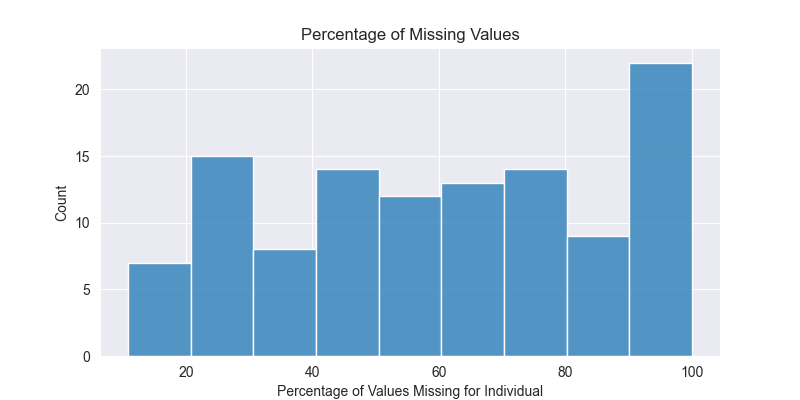

In [13]:
fig,ax = plt.subplots(figsize=(8,4))
sns.histplot(df_summary['missing_percent'], ax=ax, binwidth=10)
ax.set_title('Percentage of Missing Values')
ax.set_xlabel('Percentage of Values Missing for Individual')
plt.show()

The picture shows that there are a very small number of people that have less than 20% of data missing at intervals of 15 minutes, based on crude parameters of the range between min and max dates in their time series. The following summarises further those that are only missing less than 50 percent of their data, which is still high. Such crude analysis will become tighter as we look at specifically how this impacts the outcomes that we want from the data, as it might not be as impactful depending on what our per-day missing data looks like.

In [14]:
less_50pcnt = df_summary[df_summary['missing_percent']<50].index.values
print(f'n of individuals with less than 50% missing: {len(less_50pcnt)}')

n of individuals with less than 50% missing: 44


In [15]:
df_summary.loc[less_50pcnt].sort_values(by='missing_percent').head(5)

start                       end  samples  nans  \
86286077 2020-02-24 22:00:00+00:00 2020-03-02 23:45:00+00:00      606   NaN   
66937570 2018-08-22 05:30:00+00:00 2018-09-21 23:45:00+00:00     2571   NaN   
98974339 2017-03-11 14:15:00+00:00 2017-05-10 23:45:00+00:00     4961   NaN   
66836068 2017-12-14 08:15:00+00:00 2018-02-15 16:15:00+00:00     5165   NaN   
37875431 2017-03-18 06:00:00+00:00 2017-04-22 23:45:00+00:00     2901   NaN   

          intervals  missing_samples  total_missing       days  peaks  \
86286077        680               74             74   7.083333     24   
66937570       2954              383            385  30.770833     87   
98974339       5799              838            846  60.406250    208   
66836068       6081              916            920  63.343750    296   
37875431       3432              531            531  35.750000    104   

          peaks_interpolated  peaks_diff_int  peaks_change_int  \
86286077                  25               1          4.166667   
66937570                 117              30         34.482759   
98974339                 288              80         38.461538   
66836068                 384              88         29.729730   
37875431                 131              27         25.961538   

          peaks_diff_zeros  peaks_change_zeros  missing_percent  \
86286077                 2            8.333333        10.882353   
66937570                78           89.655172        13.033175   
98974339               189           90.865385        14.588722   
66836068               241           81.418919        15.129091   
37875431                62           59.615385        15.472028   

          days_with_data  days_missing_data  
86286077               8          -0.916667  
66937570              31          -0.229167  
98974339              61          -0.593750  
66836068              64          -0.656250  
37875431              36          -0.250000

## Imputation methods for missing values

We have chosen an arbitrary condition for peeople with less than 50 percent of values missing and we need to look at how best to impute values. As we understand the data to be, any peak in COB would then be followed by a gradual absorption of the carbohydrates and therefore expect a tail-off of COB following a peak. It there are missing values during this tail-off, using zeros will create artificial peaks that should not be recognised as unique intakes of carbohydrates. A more sophisticated method must be used that does not create such peaks. Pandas provides the interpolate() method.

In [16]:
df_cob_interp = pd.DataFrame()

for id in less_50pcnt:
    df_indiv = cob_individual(df, id)

    # Remove NaN values. There are instances where the first values are NaNs, so are removed
    df_indiv = df_indiv[df_indiv['cob max'].notna()]

    # Reindex with all missing samples and interpolate
    df_indiv = df_indiv.reset_index(names=['id', 'datetime']).set_index('datetime')
    date_rng = get_time_series_range(df_indiv, '15min')
    df_indiv = df_indiv.reindex(date_rng)
    df_indiv['id'] = id

    # Interpolate missing values and create day column
    df_indiv['day'] = df_indiv.index.date
    df_indiv['cob max'] = df_indiv['cob max'].interpolate(method='time')

    # Reset index to id and datetime
    df_indiv = df_indiv.reset_index(names='datetime').set_index(['id','datetime'])

    df_cob_interp = pd.concat([df_cob_interp, df_indiv])

df_cob_interp.head(5)

cob max         day
id       datetime                                      
86025410 2017-03-30 03:30:00+00:00      0.0  2017-03-30
         2017-03-30 03:45:00+00:00      0.0  2017-03-30
         2017-03-30 04:00:00+00:00      0.0  2017-03-30
         2017-03-30 04:15:00+00:00      0.0  2017-03-30
         2017-03-30 04:30:00+00:00      0.0  2017-03-30

Start of time series: 2017-08-09 15:45:00+00:00
End of time series: 2017-08-12 23:30:00+00:00
Samples: 248
NaN values: 0
15-minute intervals in range: 320
Missing samples: 72
Total missing (NaNs and missing): 72
Days in range: 3.3333333333333335
Number of COB peaks: 15
Number of interpolated COB peaks: 27
Difference in peaks (interpolated values): 12
% difference from pre-interpolation: 80.0
Difference in peaks (zeroed values): 28
% difference from pre-zeroing: 186.66666666666666
Total % missing: 22.5
Days with COB data: 4
Days with missing data: -0.6666666666666665


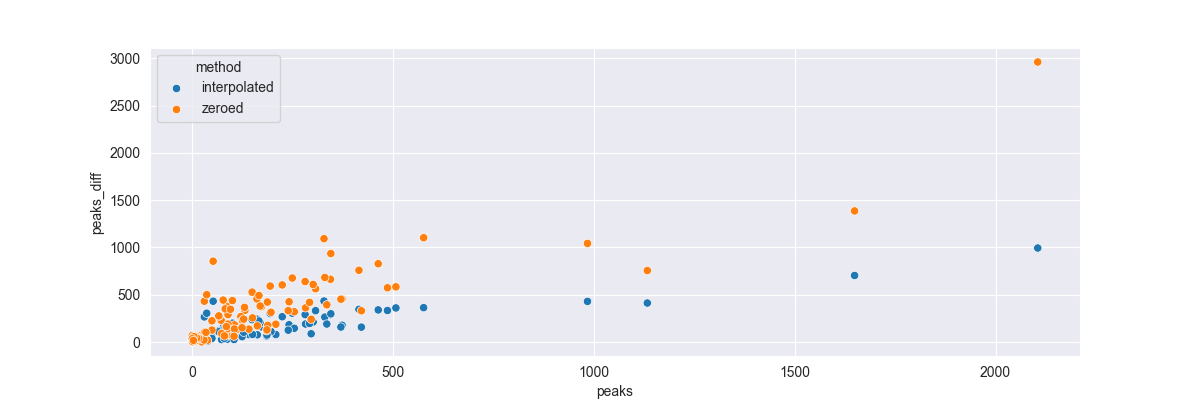

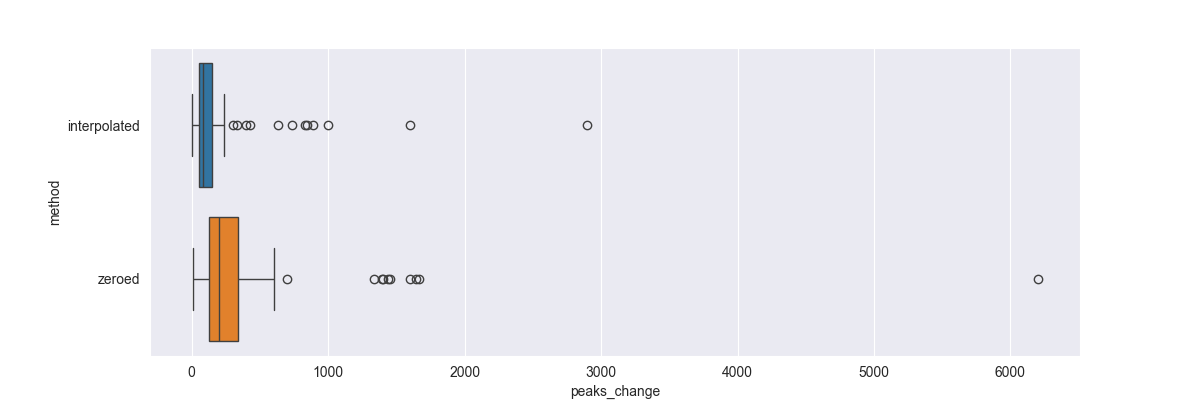

In [17]:
id = 87770486
pre_interp = cob_individual(df, id)
cob_missing_summary(pre_interp, id)
post_interp = df_cob_interp[df_cob_interp.index.get_level_values('id')==id]
peaks_int_summary = (df_summary[['peaks','peaks_diff_int','peaks_change_int']]
                     .rename(columns={'peaks_diff_int':'peaks_diff','peaks_change_int':'peaks_change'}))
peaks_int_summary['method'] = 'interpolated'
peaks_zeros_summary = (df_summary[['peaks','peaks_diff_zeros','peaks_change_zeros']]
                       .rename(columns={'peaks_diff_zeros':'peaks_diff','peaks_change_zeros':'peaks_change'}))
peaks_zeros_summary['method'] = 'zeroed'
peaks_summary = pd.concat([peaks_int_summary, peaks_zeros_summary])

fig,ax = plt.subplots(figsize=(12,4))
sns.scatterplot(data=peaks_summary[peaks_summary['peaks_diff']!=0], 
                x='peaks', 
                y='peaks_diff', 
                hue='method', 
                legend='auto', 
                ax=ax)
plt.show()

fig,ax = plt.subplots(figsize=(12,4))
sns.boxplot(data=peaks_summary[peaks_summary['peaks_change'].notna()], 
            x='peaks_change', 
            y='method', 
            orient='h', 
            ax=ax, 
            hue='method')
plt.show()

In [18]:
print('ANALYSIS SUMMARY FOR IMPUTATION METHODS FOR INDIVIDUALS WITH LESS THAN 50% MISSING VALUES')
print('This compares the number of peaks in the original data with the number of peaks in the data after imputation')
print('-----------------------------------------------------')
print(f'Mean peak difference for interpolated: {peaks_summary[peaks_summary["method"]=="interpolated"]["peaks_diff"].mean():.2f}')
print(f'Mean peak difference for zeroed: {peaks_summary[peaks_summary["method"]=="zeroed"]["peaks_diff"].mean():.2f}')
print(f'Mean peaks change for interpolated: {peaks_summary[peaks_summary["method"]=="interpolated"]["peaks_change"].mean():.2f}%')
print(f'Mean peaks change for zeroed: {peaks_summary[peaks_summary["method"]=="zeroed"]["peaks_change"].mean():.2f}%')

ANALYSIS SUMMARY FOR IMPUTATION METHODS FOR INDIVIDUALS WITH LESS THAN 50% MISSING VALUES
This compares the number of peaks in the original data with the number of peaks in the data after imputation
-----------------------------------------------------
Mean peak difference for interpolated: 131.49
Mean peak difference for zeroed: 301.45
Mean peaks change for interpolated: 188.29%
Mean peaks change for zeroed: 382.65%


In [19]:
print('Test that these two means are significantly different')
sample1 = peaks_summary[peaks_summary['method']=='interpolated']['peaks_change'].dropna()
sample2 = peaks_summary[peaks_summary['method']=='zeroed']['peaks_change'].dropna()
t_stat, p_value = ttest_ind(sample1, sample2)
print(f'T-statistic value: {t_stat:.2f}') 
print(f'P-Value: {p_value:.2f}')
if p_value < 0.05:
    print('Significant difference between the two means, given that p-value is less than 0.05')
else:
    print('No significant difference between the two means, given that p-value is greater than 0.05')

Test that these two means are significantly different
T-statistic value: -2.50
P-Value: 0.01
Significant difference between the two means, given that p-value is less than 0.05


Based on the outcome of this analysis, using imputation of zero values increases the number of peaks consistently and with significance. We shall continue with the interpolate method and check our find_peaks parameters respond as expected. To recap now, we have:
 - df: Raw 15 minute samples for n=116, with COB, IOB, BG
 - dfagg: Summary by individual of date range, COD, IOB and BG counts
 - df_summary: Statistical COB analysis of all people with less than 50% values missing at 15min intervals
 - df_cob_interp: Full COB interpolated data for all people with less than 50% values missing 15min intervals

Missing values produce unanticipated results with find_peaks, which is what we have see with the distance parameter. Changing distance was discounting points further in time than we would expect, because it is looking at sample steps. If samples were missing at the expected intervals, this meant that - for instance - 4 steps might discount a point 2 hours aways, rather than only an hour away as expected. We now need to check all data for missing values and impute where possible.

Imputation should not be an issue in our dataset considering we are looking for peaks. Instances where missing values may have been peaks themselves will have to be accepted. There is no way for us to know nor model this, without using or understanding the broader dataset, which at this point we don't. The imputation method might depend on a number of factors, not least the size of the gaps we have in the data. So lets first build some analysis around that.

In [20]:
df_cob[['cob max']].head(5)

cob max
id       datetime                          
90398368 2019-05-21 19:30:00+00:00      NaN
         2019-05-21 19:45:00+00:00      NaN
         2019-05-21 20:00:00+00:00      NaN
         2019-05-21 20:15:00+00:00      NaN
         2019-05-21 20:30:00+00:00      NaN

Lets look through a sample of plots for individuals to see if there are any other anomolies worth noting.

The following looks to use sliders to be able to adjust the parameters and visually tune the parameters for peak detection to optimise for our use.

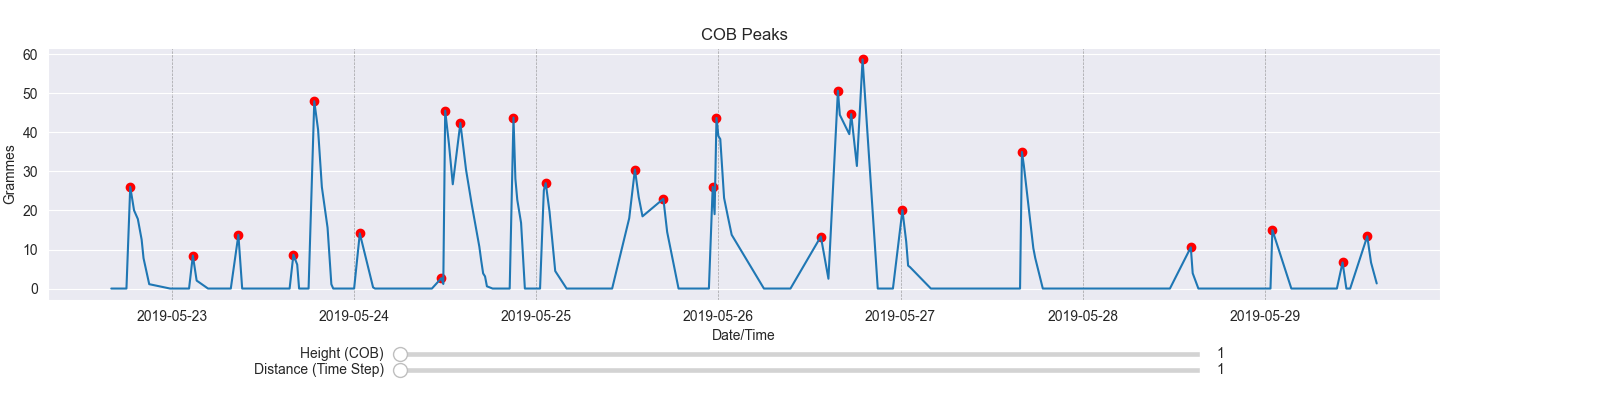

In [21]:
def plot_peaks_dynamic(df: pd.DataFrame, x: str = 'cob max'):
    init_h = 1
    init_d = 1

    fig, ax = plt.subplots(figsize=(16,4))
    ax.plot(df.index.get_level_values('datetime'), df[x])
    peaks, _ = cob_peaks(df[x], h=init_h, d=init_d)
    df_pk = df.iloc[peaks]
    scat = ax.scatter(df_pk.index.get_level_values('datetime'), df_pk[x], c = 'red')
    ax.set_ylabel('Grammes')
    ax.set_xlabel('Date/Time')
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
    ax.xaxis.grid(which='major', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.xaxis.grid(which='minor', color='gray', linestyle=':', linewidth=0.2)
    plt.title('COB Peaks')

    # Adjust the subplots region to leave some space for the sliders and buttons
    fig.subplots_adjust(left=0.03, bottom=0.25)

    # Make a horizontal slider to control the height.
    ax_h = fig.add_axes([0.25, 0.1, 0.5, 0.03])
    h_slider = Slider(
        ax = ax_h,
        label = 'Height (COB)',
        valmin = 1,
        valmax = 60,
        valstep = 1,
        valinit = init_h
    )

    ax_d = fig.add_axes([0.25, 0.06, 0.5, 0.03])
    d_slider = Slider(
        ax = ax_d,
        label = 'Distance (Time Step)',
        valmin = 1,
        valmax = 10,
        valstep = 1,
        valinit = init_d
    )

    # The function to be called anytime a slider's value changes
    def update(val):
        peaks,_ = cob_peaks(df[x], h=h_slider.val, d=d_slider.val)
        df_pk = df.iloc[peaks]
        x_dates = mdates.date2num(df_pk.index.get_level_values('datetime'))
        scat.set_offsets(np.column_stack((x_dates, df_pk[x].values)))
        fig.canvas.draw_idle()

    # register the update function with each slider
    h_slider.on_changed(update)
    d_slider.on_changed(update)
    
    plt.show()
    
plot_peaks_dynamic(df_cob, x='cob interpolated')


By now we are building up a method to pre-process the data for each individual which includes padding missing intervals, interpolating the data and finding peaks, which we can add to our dataset as a feature. We keep the indices of peaks separate to plot them easily. We use our new method to take a look at the first 20 in the sample to review what visualising the data more broadly tells us about missing values. We are setting the parameters as h=15 and d=5 based on learning from the study of parameter values in the coming section.

In [22]:
def prep_cob_individual(id: int, df: pd.DataFrame, peak_h=1, peak_d=1):
    """
    Prepares the COB data for an individual, interpolating missing values, identifying peaks and adding the day for aggregation.

    Parameters:
        id (int): Individual ID
        df (pd.DataFrame): DataFrame containing COB data
        peak_h (int): Height for peak finding
        peak_d (int): Distance for peak finding

    Returns:
        df_id (pd.DataFrame): DataFrame containing individual COB data with interpolated values, datetime as index
        peak_indices (np.array): Array of indices for peaks
    """
    df_id = cob_individual(df, id)
    dr = get_time_series_range(df_id, '15min')
    df_id = df_id.reset_index(names=['id', 'datetime']).set_index('datetime')
    df_id = df_id.reindex(dr)
    df_id['cob interpolated'] = df_id['cob max'].interpolate(method='time')
    df_id['day'] = df_id.index.date
    df_id['id'] = id
    df_id = df_id.reset_index(names='datetime').set_index(['id','datetime'])
    peak_indices, _ = cob_peaks(df_id['cob interpolated'], h=peak_h, d=peak_d)
    df_id['peak'] = 0
    df_id.loc[df_id.index[peak_indices], 'peak'] = 1
    return df_id, peak_indices


Individual 90398368


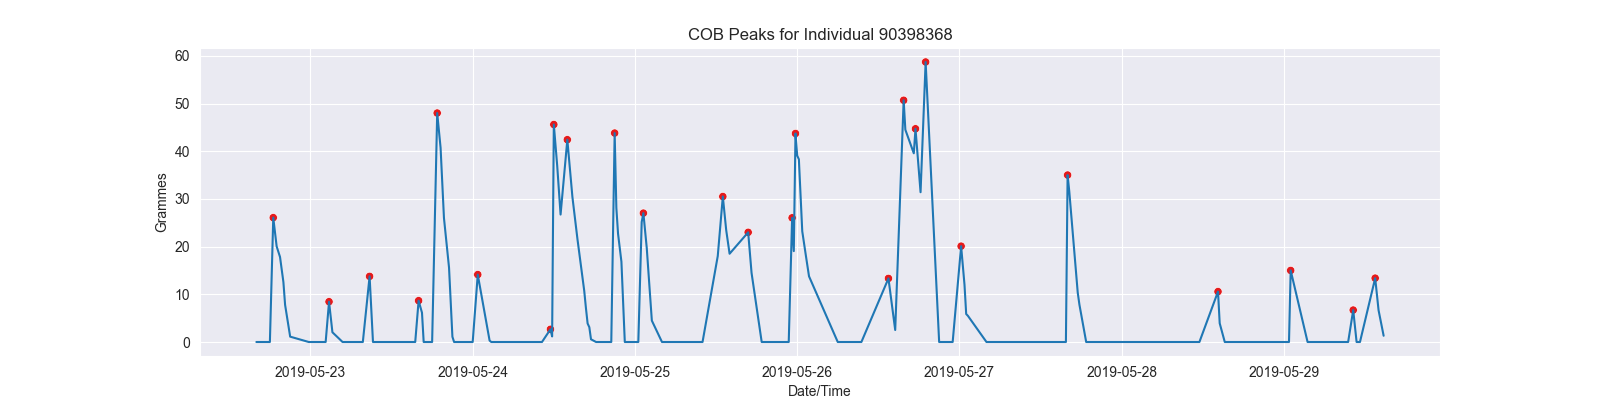

Individual 86025410


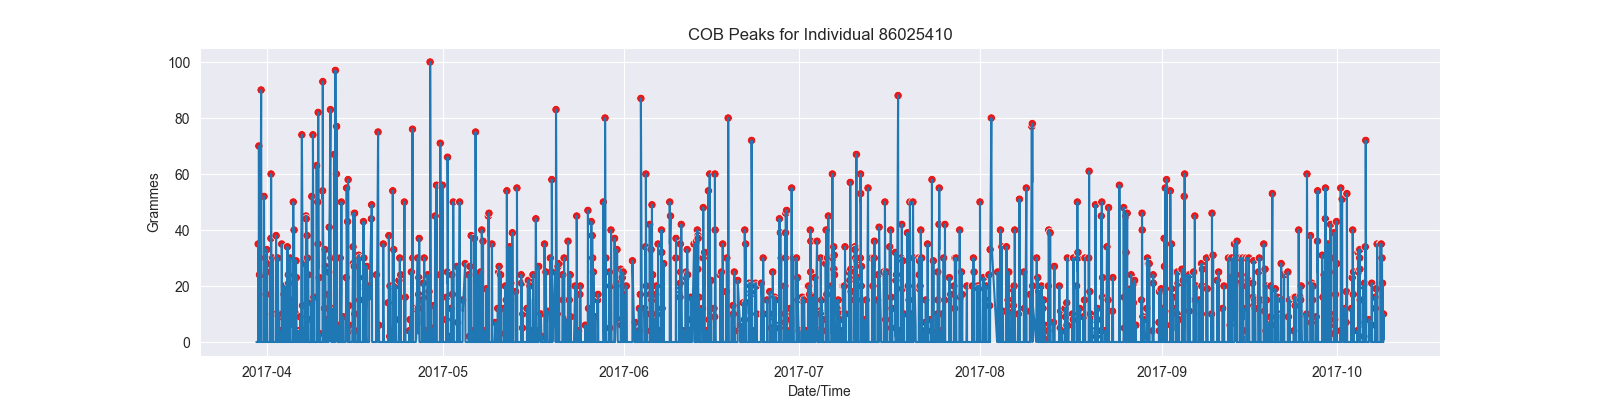

Individual 66937570


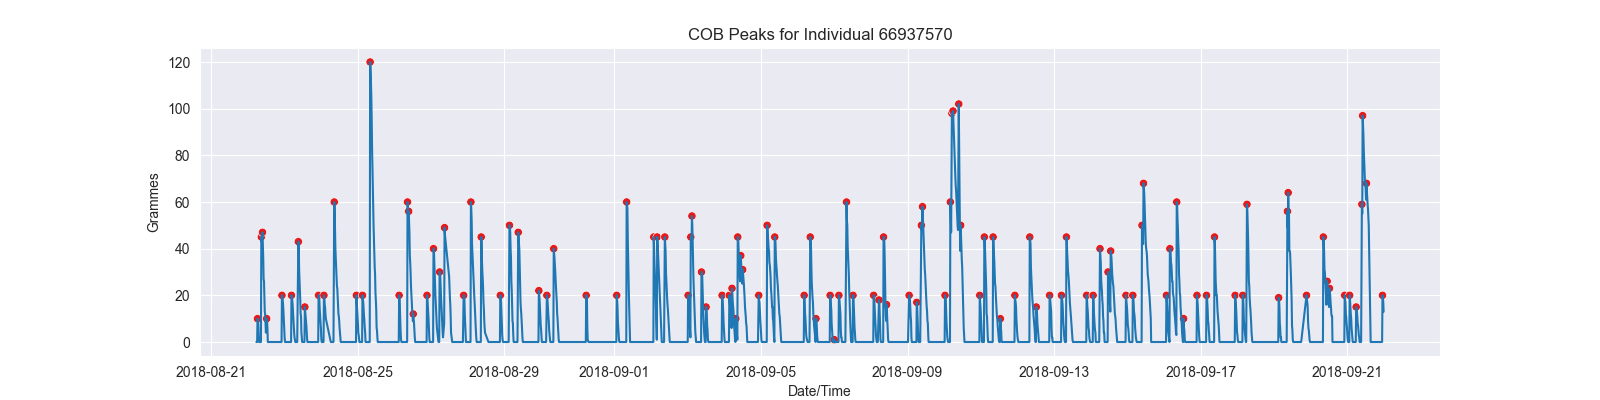

Individual 38110191


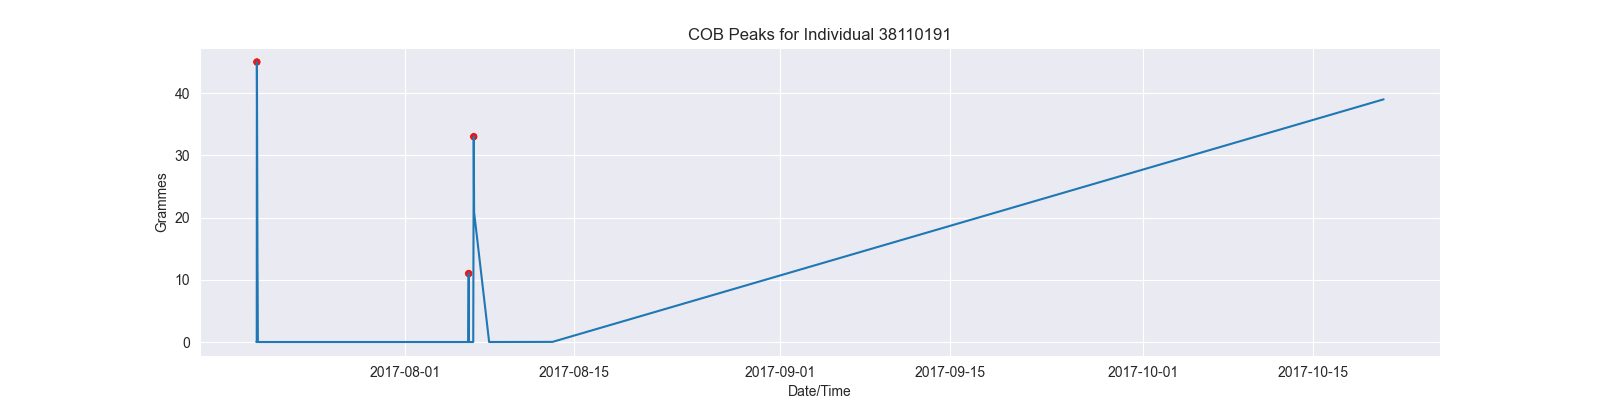

Individual 70454270


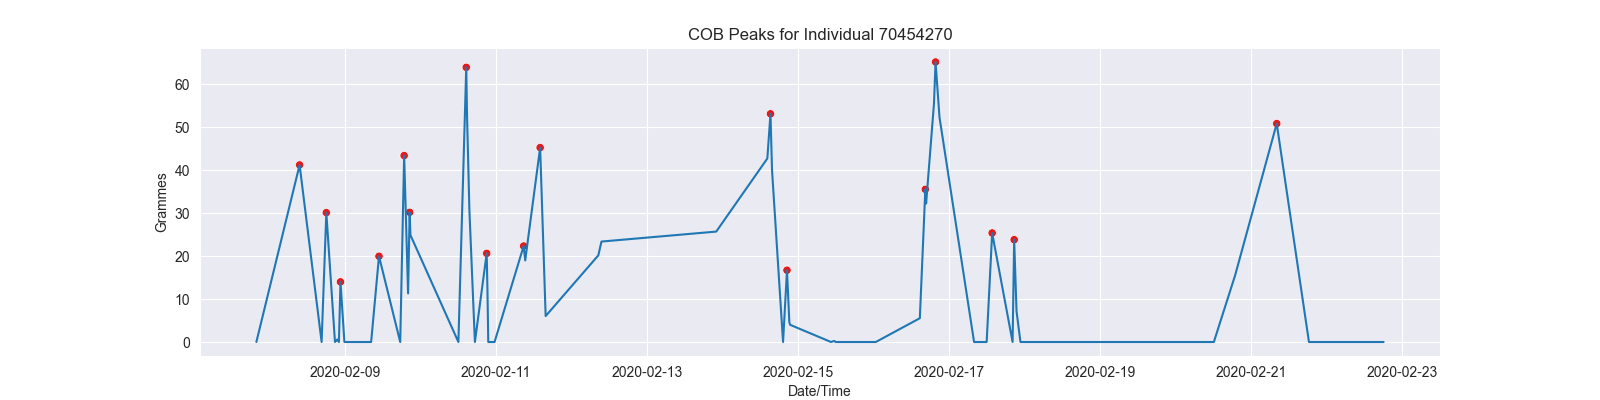

Individual 4762925


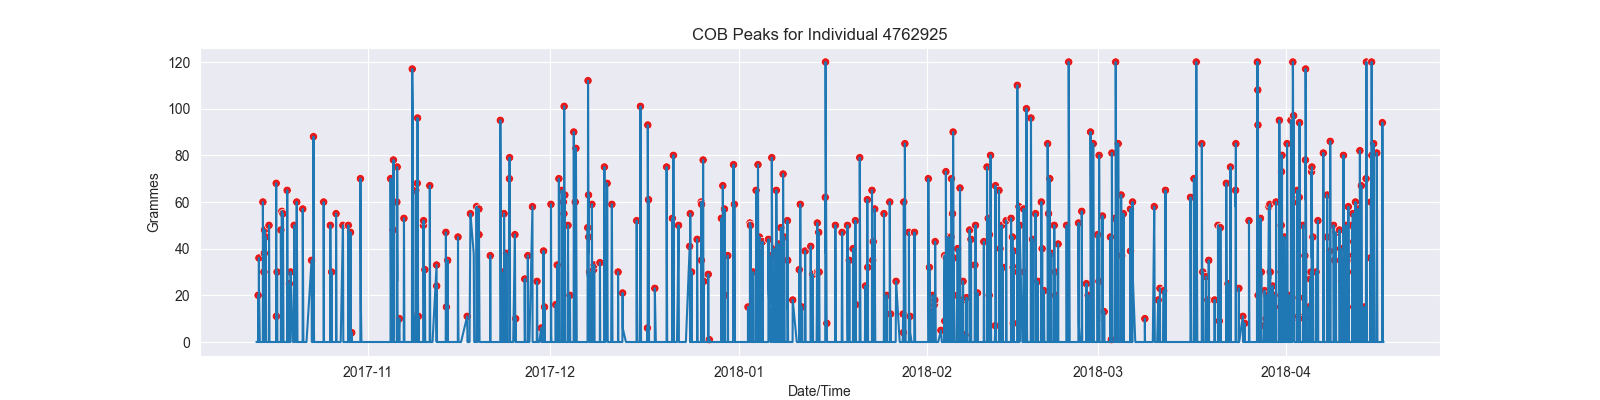

Individual 16975609


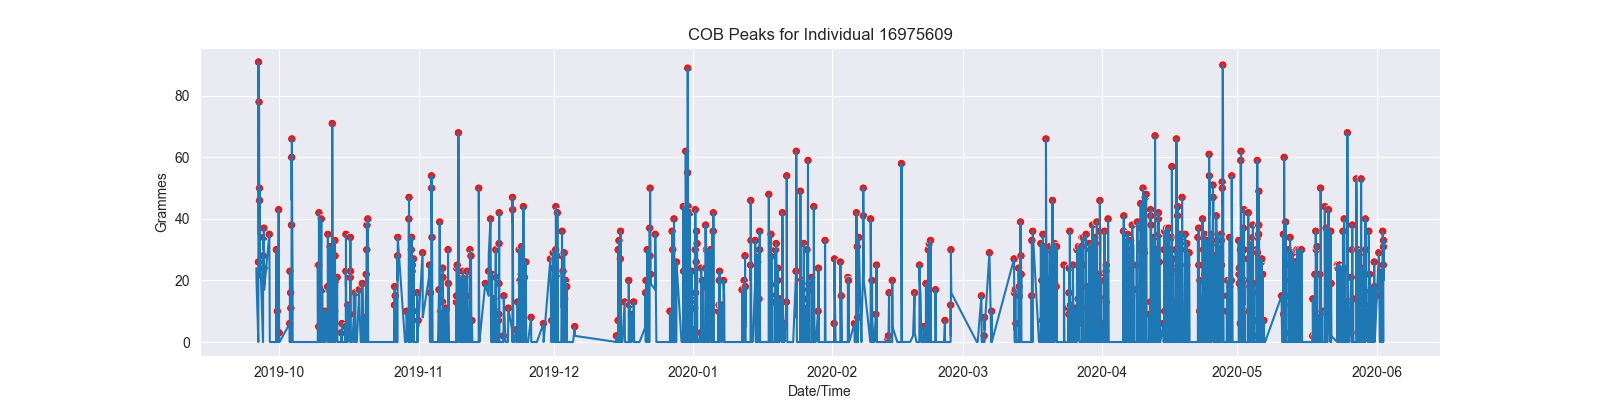

Individual 88252802


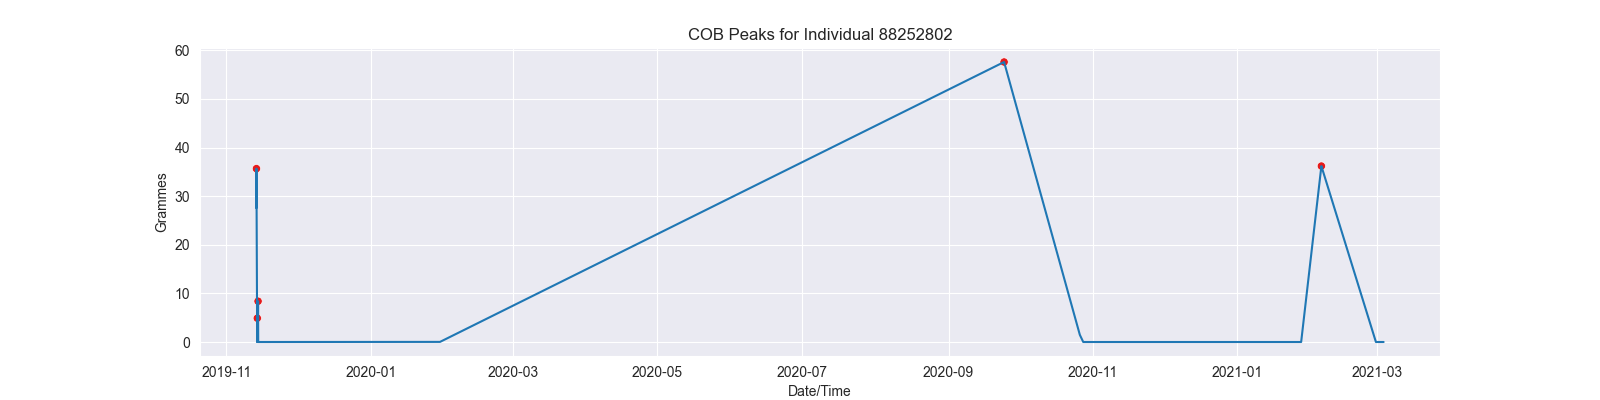

Individual 897741


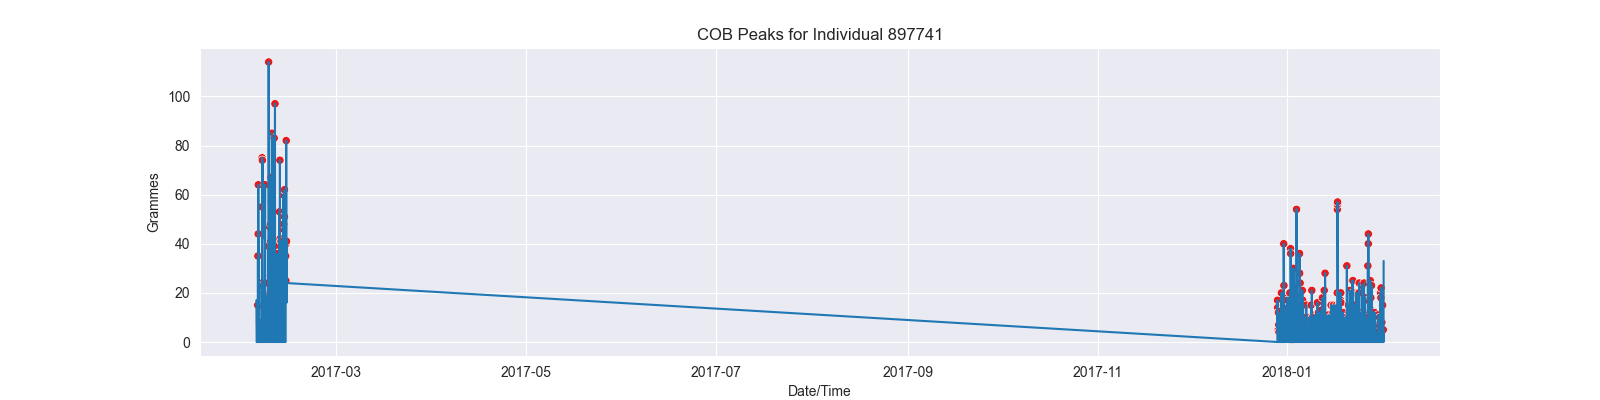

Individual 13029224


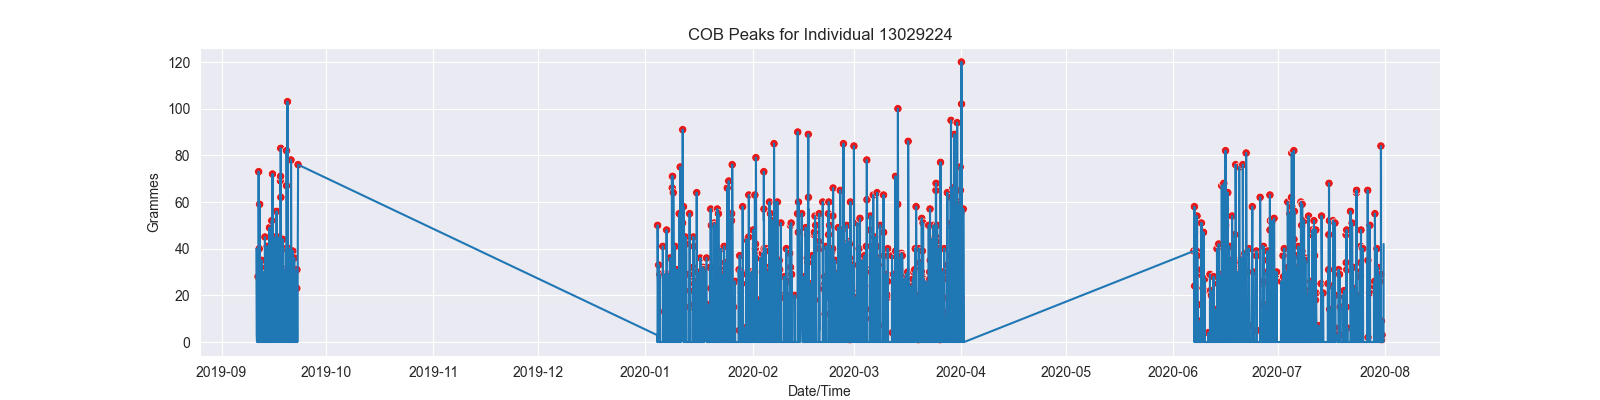

Individual 28176124


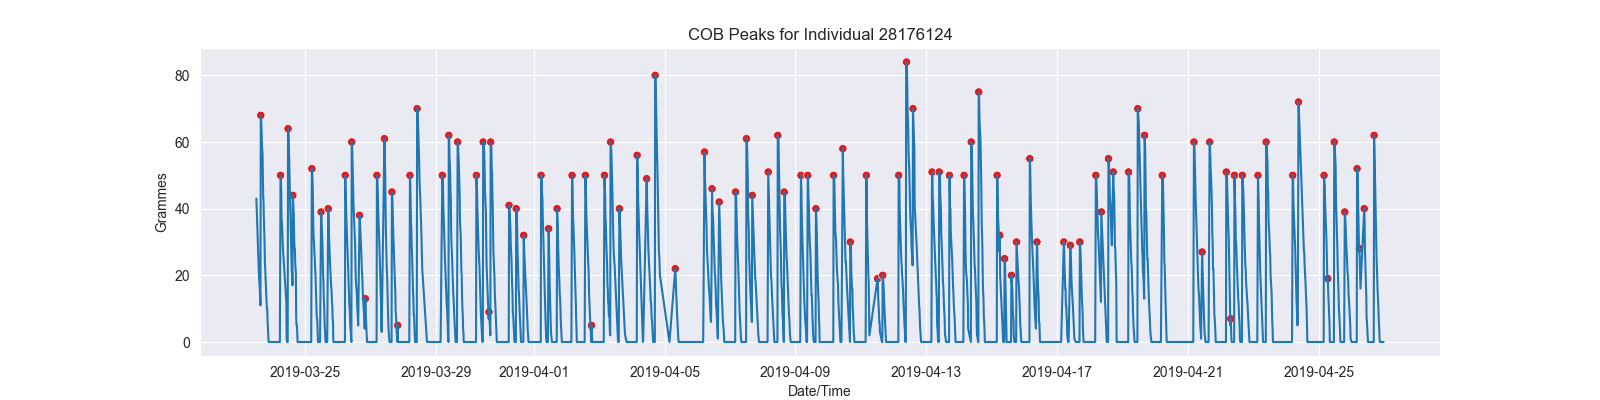

Individual 99296581


C:\Users\ross\AppData\Local\Temp\ipykernel_29540\2523325770.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(16,4))


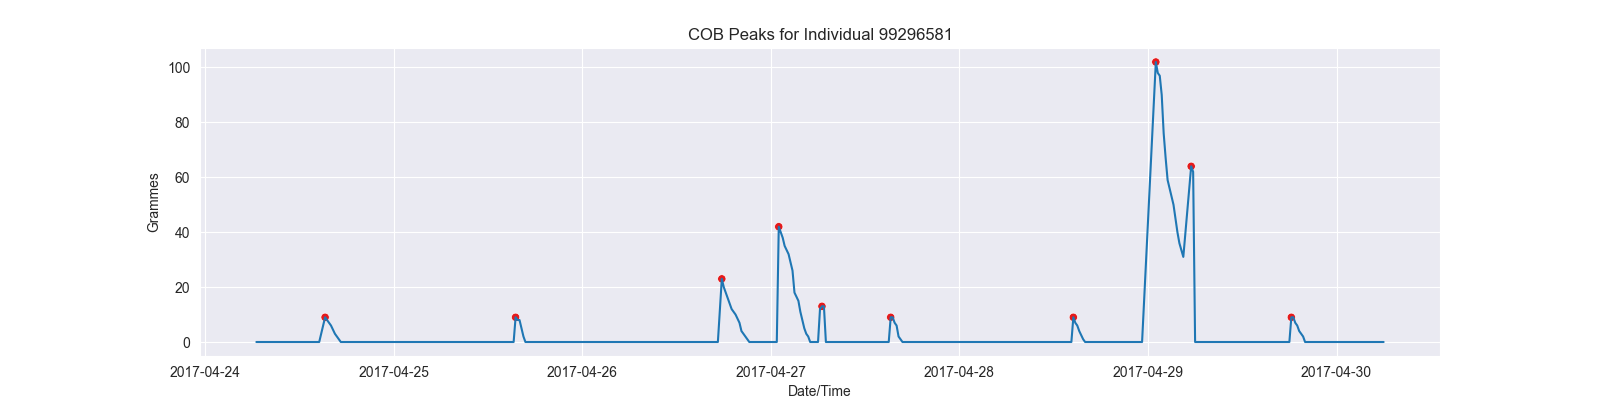

Individual 94200862


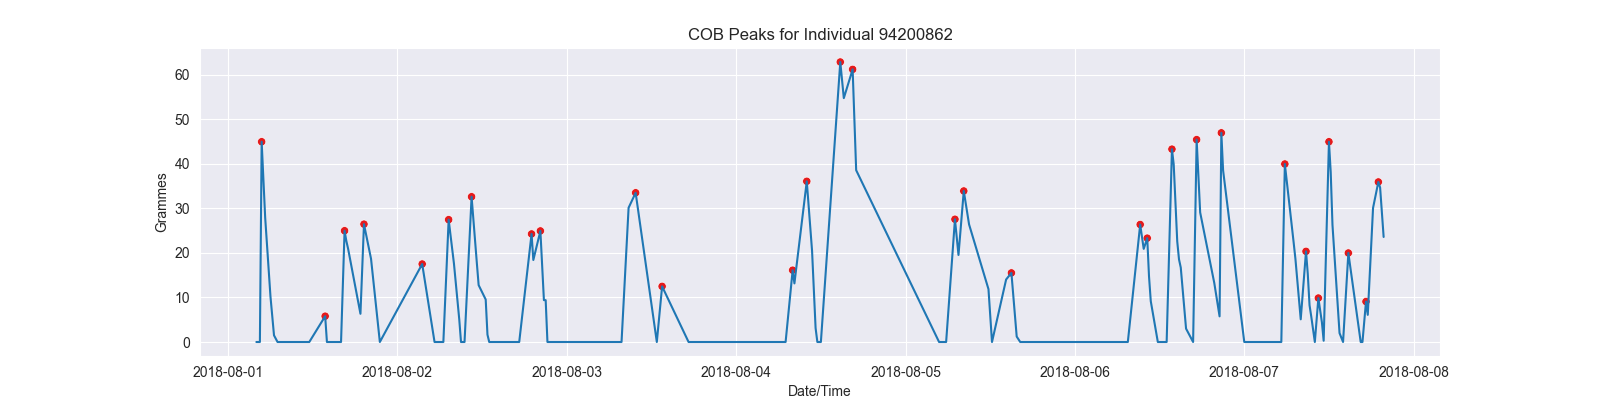

Individual 19626656


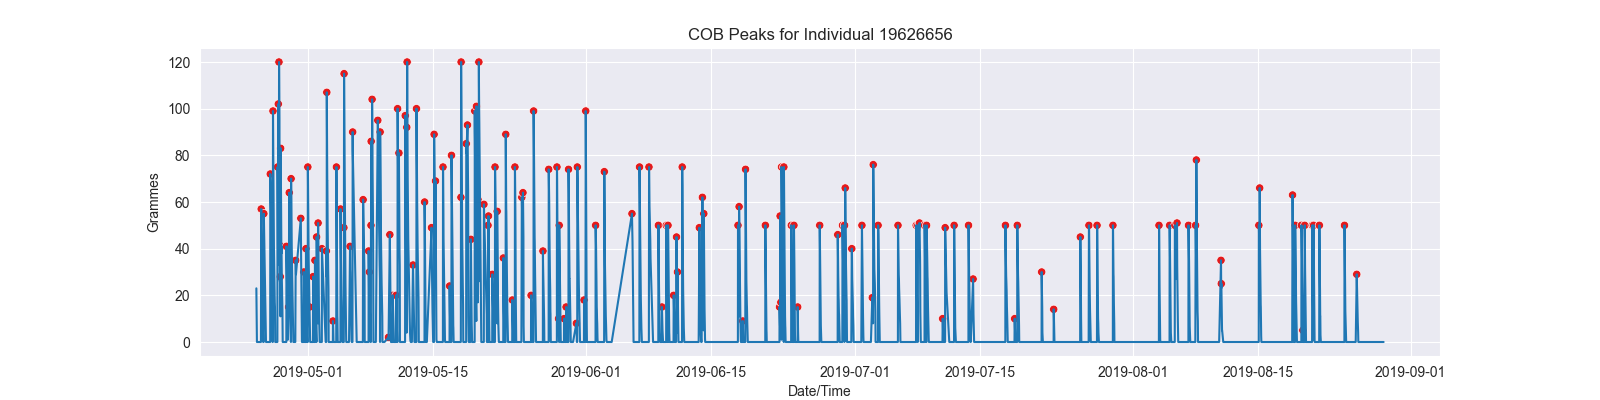

Individual 95851255


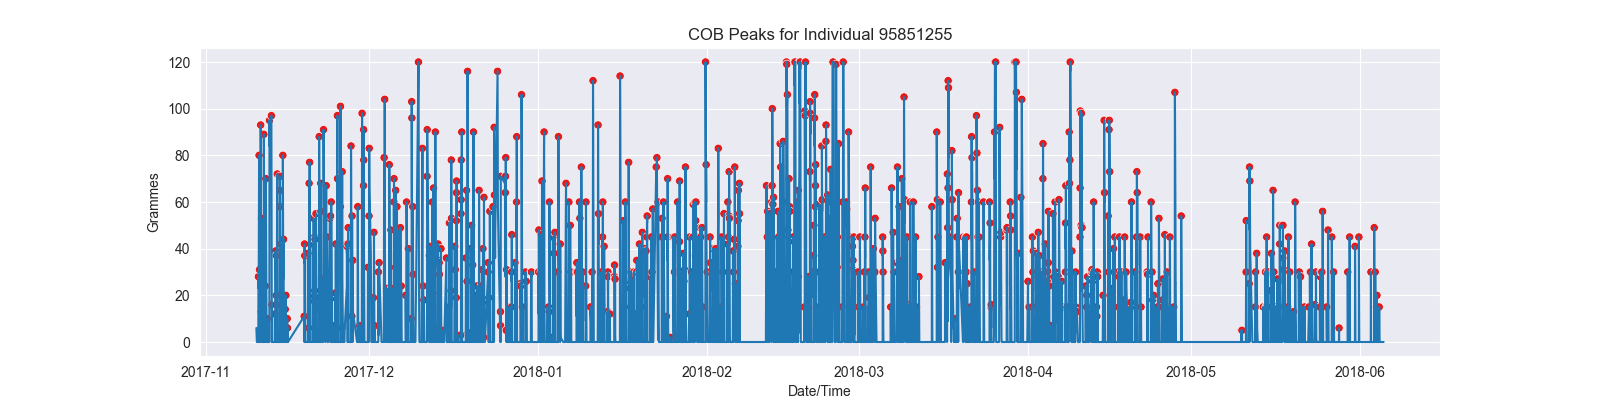

Individual 86323903


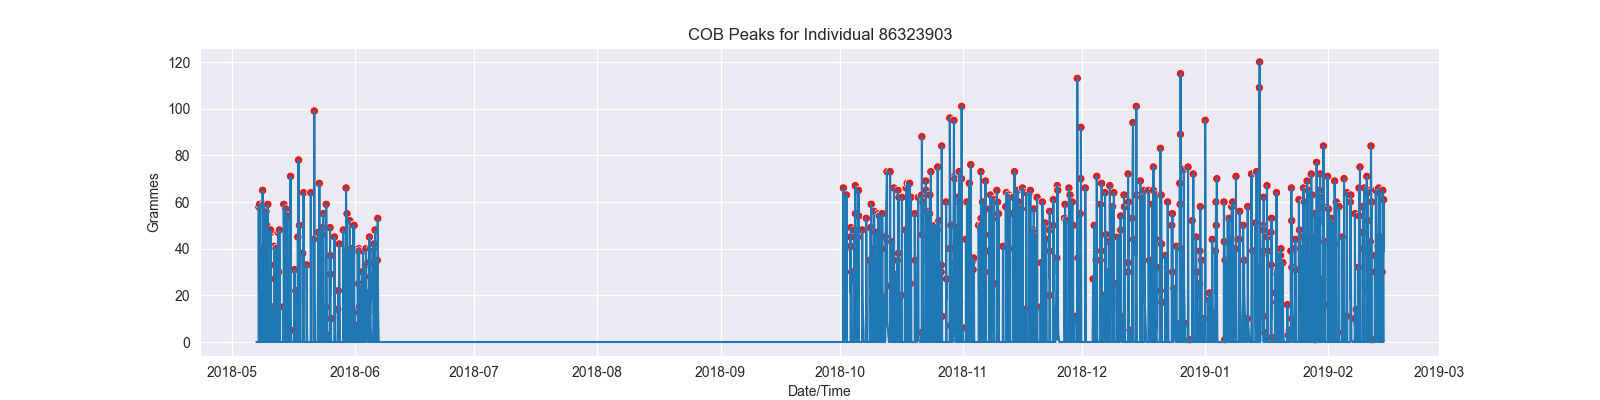

Individual 43589707


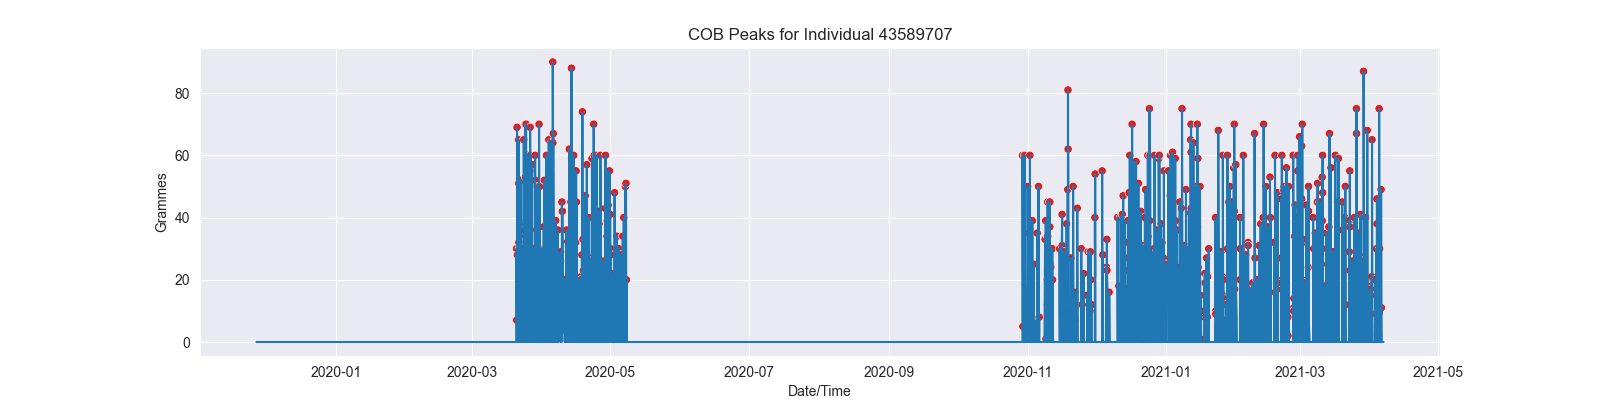

Individual 41131654


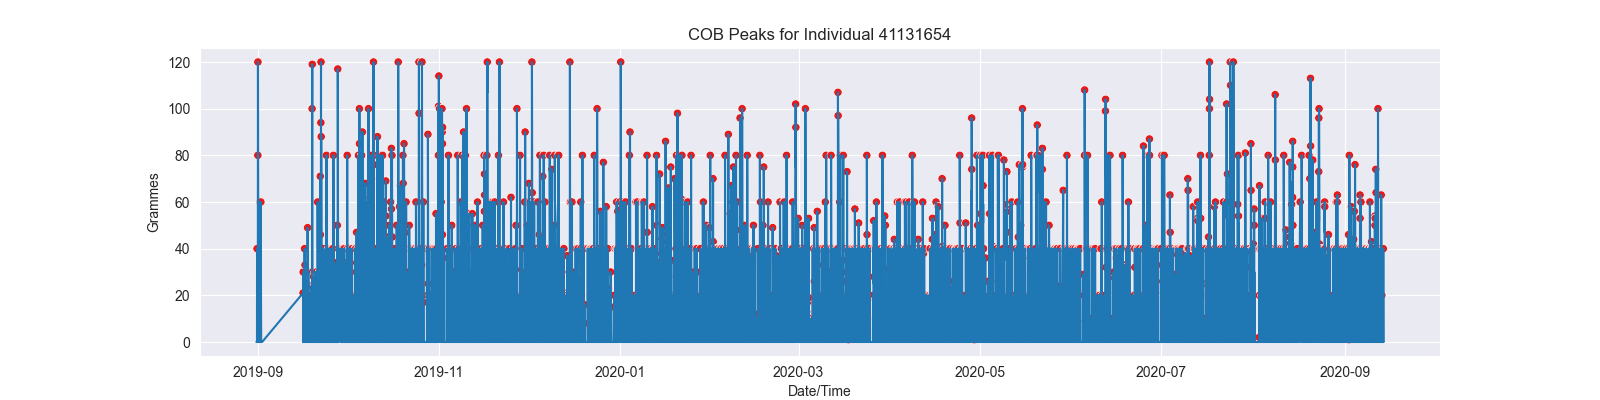

Individual 20216809


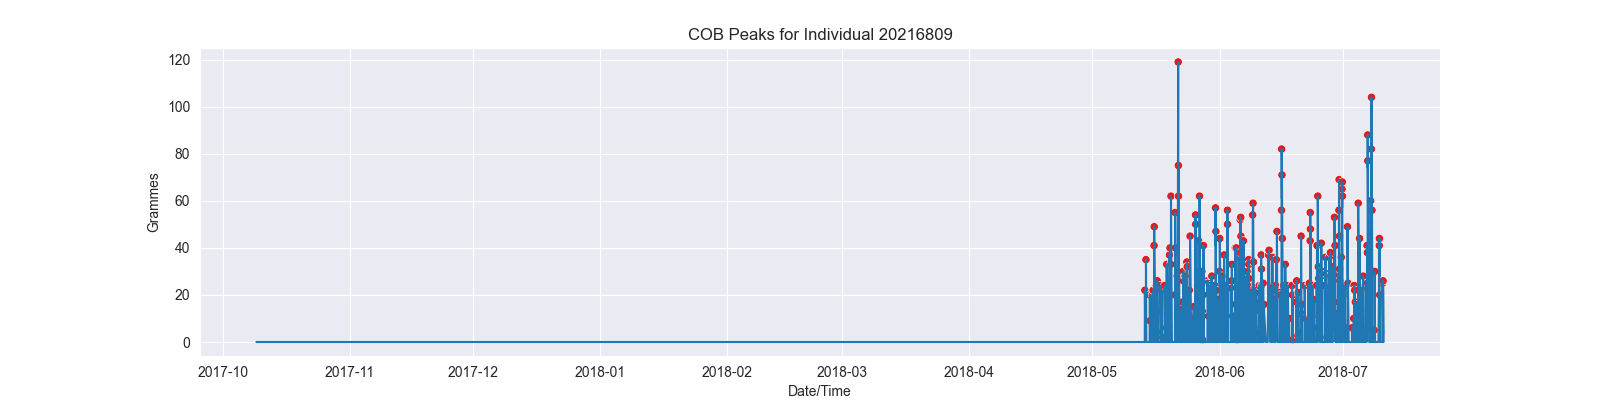

Individual 64024750


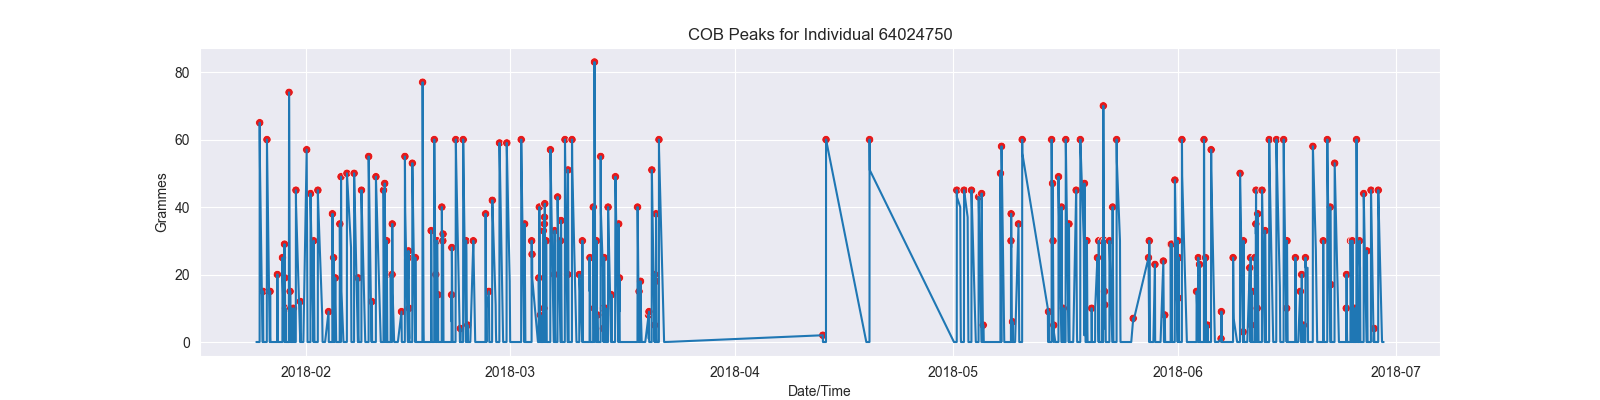

In [23]:
# Plot the peaks for the first 20 individuals to see if there are any patterns
for id in df['id'].drop_duplicates().values[:20]:
    print(f'Individual {id}')
    df_indiv, peak_indices = prep_cob_individual(id, df)
    plot_peaks(df_indiv, peak_indices, y='cob interpolated', title=f'COB Peaks for Individual {id}')

This shows that almost half of the individuals have missing intervals for a day that are likely multimodal. This demonstrates that there is a phenomena in the data that we suspected and should somehow address. It would be useful to know what the means are for each of the separate modes in the distribution to see if there is a correlation. The hypothesis is that this might centre around the high end (96 intervals per day). We can use our find_peaks() function or Gaussian Mixture Models. We'll compare the output of both.

There are two issues that are obvious from these plots:
1. There are date ranges for some individuals where there exists no data. These must be excluded from our dataset. At present we are not dealing with this issue and it is key to ensuring such missing data is not included in any modelling we later do.
2. Interpolation is making the incorrect assumption based on the existence of long upward gradients leading to a peak. This would not happen in reality and is representative of missing data prior to the peak which the interpolation is substituting values for. In itself, this is not an issue when finding peaks. The algorithm is not concerned with this characteristic and it does not impact the outcome. However, it is another example of why missing data needs addressing.

### Defining 'complete' days

To address these issues, it is important to remember the data that is important to us, as it will shape the approach. For this part of our analysis, our concern is with having complete individual days of data rather than continuous sequences across a date range. As such we need to address what we deem to be a 'complete' day. We have no infomation on the diet regimen of our subjects is. In fact, we know it can vary greatly depending on the individual. While the recommended intake of carbohydrates according to Trumbo et al (2002) is 130 grammes per day, it is possible for diabetics to follow low-calorie diets (LCD: <=130g) or even a very low calorie diets (VLCD: 20g-50g) given they might see benefits of this in terms of glycaemic control. This makes it difficult to use total carbohydrate intake per day as a measure to mask days. A more accurate method would be to eliminate days where there is a discernably less carbohydrate intake for a particular day compared to what might be 'normal'.

In order for there to be ample comparison, we would first expect there to be a minimum number of days data to be able to identify outliers. Lets set this parameter initially to 5. Lets create a method to identify the days to exclude. The first we'll look at is a basic statistical method. There are also possible unsupervised machine learning methods that can ideantify outliers with only one feature such as Isolation Forests, and Local Outlier Factor (LOF). It may be that we can consider other features such as the total intake for the day as well as the number of peaks, for which something like k-means might work.

Lets first look at the basic statistical method. The aim is to compare all days with the means of the days and use 2 standard deviations less than the means as the threshold of what we exclude. (Given our concern are days with missing data, it is only $Pr(\mu - 2\sigma \leq X)$ that is relevant).

For any approach, data preparation will take the following form:
1. Remove individuals without the requisite number of days data.
2. By individual, we need to pad missing time intervals and interpolate the data.
3. Create a rolling average of the interpolated data. We will look at how this compares to finding peaks without doing so. Our data isn't necessarily that noisy but there are smaller peaks we see that might not represent additional intake, rather be part of contours that that appear to be separate peaks due to missing priors in the time series.
4. Find peaks in the data.
5. Sum the peaks for rolling average and standard interpolated data (to provide a comparison)
6. Calculate total COB intake per day. Given the random variable we are using is maximum COB reading, we would only be interested in summing the COB peaks, which infers finding those peaks.
7. Sum the number of missing values per day. This might be a useful feature in future analysis.
8. Choose the appropriate peaks variable and calculated COB based on the chosen peaks output (interpolated raw, or smoothed).

In [24]:
def prep_id_for_missing_analysis(df: pd.DataFrame, rolling: bool = True):
    df['cob rolling'] = df['cob max'].rolling(window=4).mean()
    peaks_rolling, _ = cob_peaks(df['cob rolling'], h=1, d=1)
    peaks_interp, _ = cob_peaks(df['cob interpolated'], h=1, d=1)
    df['peak_rolling'] = 0
    df['peak_interp'] = 0
    df.loc[df.index[peaks_rolling], 'peak_rolling'] = 1
    df.loc[df.index[peaks_interp], 'peak_interp'] = 1
    df_agg = df.groupby('day').agg(
        peak_interp_sum=('peak_interp', 'sum'),
        peak_rolling_sum=('peak_rolling', 'sum'),
        interp_cob_sum=('cob max', lambda x: x[df['peak_interp'] == 1].sum()),
        rolling_cob_sum=('cob max', lambda x: x[df['peak_rolling'] == 1].sum()),
        missing=('cob max', lambda x: x.isnull().sum())
    )
    return df, df_agg

# Example Individual: Long trailing missing values
id = 20216809

df_cob, _ = prep_cob_individual(id, df)
df_cob, df_cob_agg = prep_id_for_missing_analysis(df_cob)
df_cob_agg.tail(5)


peak_interp_sum  peak_rolling_sum  interp_cob_sum  \
day                                                             
2018-07-06                4                 0           118.0   
2018-07-07                5                 2           288.0   
2018-07-08                5                 1           277.0   
2018-07-09                3                 1           129.0   
2018-07-10                3                 0            71.0   

            rolling_cob_sum  missing  
day                                   
2018-07-06              0.0       20  
2018-07-07            115.0       54  
2018-07-08              1.0       20  
2018-07-09             39.0       18  
2018-07-10              0.0       15

Firstly, lets choose whether the rolling average approach appears to bring any benefit. By plotting a day from the summary to compare the peaks for the rolling average against the unprocessed interpolated data, we can make a judgement.

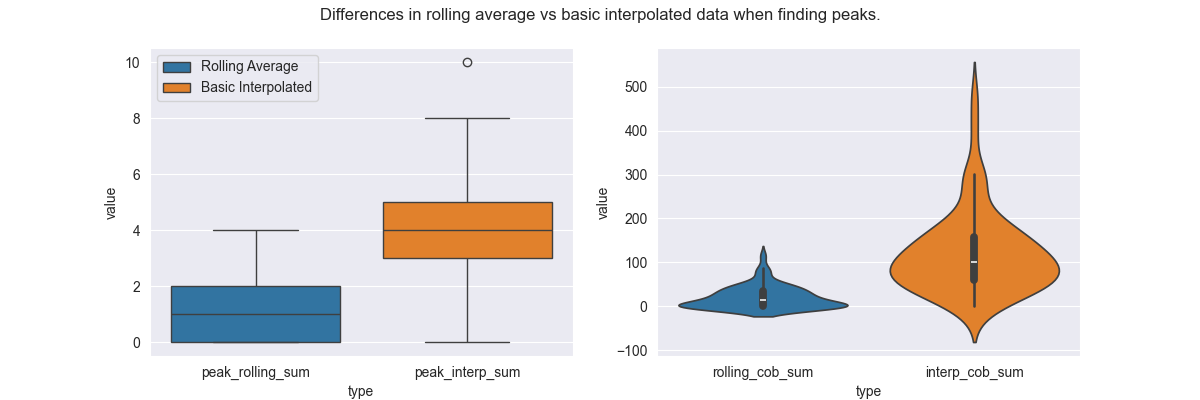

In [25]:
df_peaks_melted = (df_cob_agg[df_cob_agg['missing'] != 96]
			 .reset_index()
			 .melt(id_vars=['day'], value_vars=['peak_rolling_sum', 'peak_interp_sum'], var_name='type', value_name='value'))

df_cob_melted = (df_cob_agg[df_cob_agg['missing'] != 96]
             .reset_index()
             .melt(id_vars=['day'], value_vars=['rolling_cob_sum', 'interp_cob_sum'], var_name='type', value_name='value'))

fig,ax = plt.subplots(figsize=(12,4), ncols=2)
sns.boxplot(data=df_peaks_melted, y='value', x='type', hue='type', ax=ax[0])
ax[1] = sns.violinplot(data=df_cob_melted, y='value', x='type', hue='type', native_scale=True, zorder=1)
fig.suptitle('Differences in rolling average vs basic interpolated data when finding peaks.')
ax[0].legend(labels=['Rolling Average', 'Basic Interpolated'])
plt.show()

The use of a rolling average in our data undermines the identification of peaks in data based on the outcomes above, so we stick with the interpolated data to base the rest of our method/analysis on. Next, lets look at applying methods of discounting missing values to an individual. We'll continue with 20216809 who has a prevalence of days with no missing data and look at how we can assess days for quality of data. Using any statistical analysis would be based on the mean total COB and in the case of this subject, they have many zero-intake days which must be excluded.

In [26]:
zero_data_days = df_cob_agg[df_cob_agg['peak_interp_sum'] == 0].index
print(f'{len(zero_data_days)} days with no peaks in the interpolated data for individual {id}')
df_missing_features = df_cob_agg[['peak_interp_sum','interp_cob_sum','missing']].loc[~df_cob_agg.index.isin(zero_data_days)]
print(f'Number of days with peaks in the interpolated data: {len(df_missing_features)}')
df_missing_features.head()

216 days with no peaks in the interpolated data for individual 20216809
Number of days with peaks in the interpolated data: 59


peak_interp_sum  interp_cob_sum  missing
day                                                 
2018-05-13                1            22.0       81
2018-05-14                1            35.0       44
2018-05-15                4            71.0       22
2018-05-16                6           157.0       29
2018-05-17                2            46.0       22

We have three features here that might help us indicate the usefulness of the data based on missing values and provide a model for discriminating between useful and unhelpful samples.

In [27]:
display(df_missing_features.describe())

peak_interp_sum  interp_cob_sum    missing
count        59.000000       59.000000  59.000000
mean          4.186441      125.220339  25.830508
std           1.898044       90.586226  13.586444
min           1.000000       22.000000  10.000000
25%           3.000000       61.500000  17.000000
50%           4.000000      104.000000  20.000000
75%           5.000000      157.500000  30.000000
max          10.000000      475.000000  81.000000

The number of peaks (peak_interp_sum) and the total COB intake (interp_cob_sum) could be used with their standard deviation to remove days that might be considered outliers as a result of missing data ($X \geq \mu-2\sigma$). We'd expect these to have a high number of missing values, so lets see.

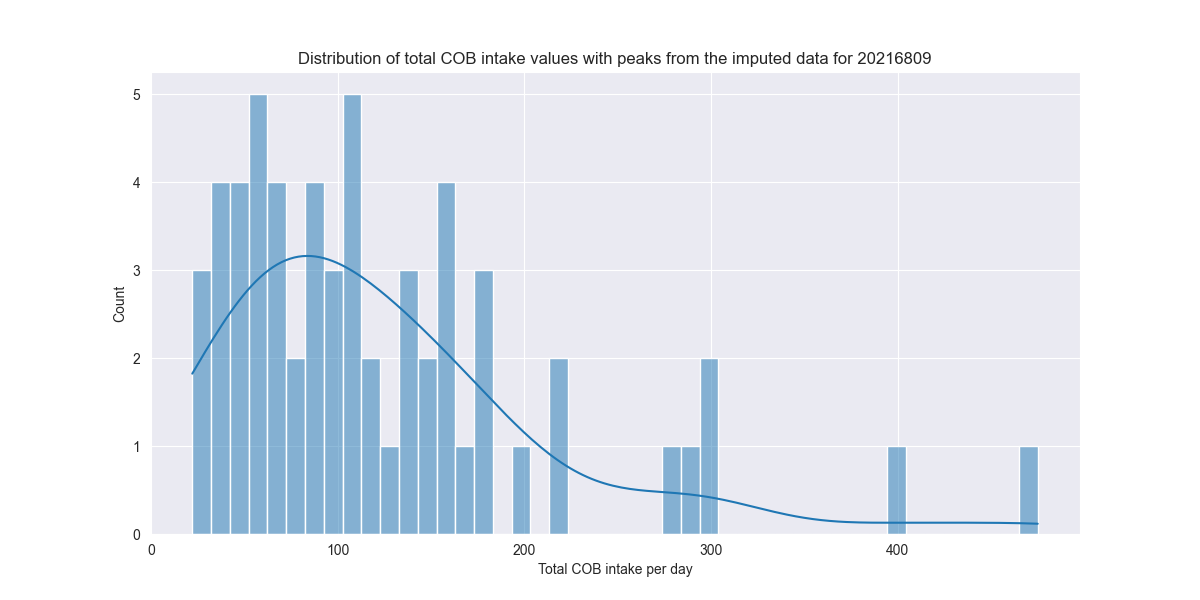

Number of days resulting from filtering out -2sd peak value from the mean: 59
Number of days resulting from filtering out -2sd COB values from the mean: 59


In [28]:
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(df_missing_features, x='interp_cob_sum', binwidth=10, kde=True)
plt.title(f'Distribution of total COB intake values with peaks from the imputed data for {id}')
ax.set_xlabel('Total COB intake per day')
plt.show()

peak_sd = df_missing_features['peak_interp_sum'].std()
peak_mean = df_missing_features['peak_interp_sum'].mean()
cob_sd = df_missing_features['interp_cob_sum'].std()
cob_mean = df_missing_features['interp_cob_sum'].mean()

print(f'Number of days resulting from filtering out -2sd peak value from the mean: {len(df_missing_features[df_missing_features["peak_interp_sum"] >= peak_mean - (2*peak_sd)])}')
print(f'Number of days resulting from filtering out -2sd COB values from the mean: {len(df_missing_features[df_missing_features["interp_cob_sum"] >= cob_mean - (2*cob_sd)])}')

This is telling as using ($X \geq \mu-2\sigma$) does not mask any of the days from the sample, likely given that there aren't sufficient days to provide significant outliers as well as the fact that the data is highly skewed to the left. Lets look at the correlation of COB intake to missing values. Lets expand the analysis to a couple more individals to see if there is anything telling in the data. We've chosen 41131654 for its completeness and range and 13029224 which has significant gaps in its ranges. 

In [29]:
# Function for pre-processing the data for a batch of individuals
def pre_process_batch(ids: list, df: pd.DataFrame):
    """
    Pre-processes the data for a batch of individuals, including interpolating missing values and identifying peaks.

    Parameters:
        ids (list): List of individual IDs
        df (pd.DataFrame): DataFrame containing COB data
    
    Returns:
        df_cob (pd.DataFrame): DataFrame containing pre-processed COB data for the batch of individuals
    """
    df_cob = pd.DataFrame()
    
    for id in ids:
        if id not in df['id'].values:
            raise ValueError(f'Individual {id} not found in dataset')
        df_indiv, _ = prep_cob_individual(id, df)
        df_cob = pd.concat([df_cob, df_indiv])
    return df_cob

# Function to remove zero peak days, accepts raw data that it groups by day and aggregates total COB intake and peak count
def remove_zero_peak_days(df: pd.DataFrame, id: int = None):
    """
    Removes days with no peaks from the dataset, based on the interpolated data.

    Parameters:
        df (pd.DataFrame): DataFrame containing COB data

    Returns:
        df_cob (pd.DataFrame): DataFrame with days with zero-data days removed
        df_agg_by_day (pd.DataFrame): DataFrame containing aggregated data by day, flagging removed days (but not removing them)
    """
    # Make a copy to avoid slicing warnings
    df_cob = df.copy()

    # Check for required columns and correct or raise error
    if 'id' not in df_cob.index.names and id:
        df_cob['id'] = id
        df_cob = df_cob.reset_index(names='datetime').set_index(['id', 'datetime'])
    elif 'id' not in df_cob.index.names:
        raise ValueError('ID column not found in DataFrame')
    if 'day' not in df_cob.columns:
        df_cob['day'] = df_cob.index.date
    if 'peak' not in df_cob.columns:
        raise ValueError('No peak column found in DataFrame')

    # Aggregate by day
    df_agg_by_day = df_cob.groupby(['id','day']).agg(
        peak_interp_sum=('peak', 'sum'),
        interp_cob_sum=('cob max', lambda x: x[df_cob['peak'] == 1].sum()),
        missing=('cob max', lambda x: x.isnull().sum()))
    
    # Set flag for removed days based on no peaks or all missing values
    df_agg_by_day['removed'] = 0
    df_agg_by_day.loc[df_agg_by_day['peak_interp_sum'] == 0, 'removed'] = 1
    zero_data_days = df_agg_by_day[df_agg_by_day['removed'] == 1].index
    df_cob = df_cob.loc[~df_cob['day'].isin(zero_data_days)]
    ids = df_cob.index.get_level_values('id').drop_duplicates()
    days = df_cob["day"].drop_duplicates()
    if len(ids) > 1 and len(zero_data_days) > 0:
        print(f'For batch of {len(ids)} individuals: {len(zero_data_days)} days with no peaks removed, {len(days)} remain.')
    elif len(ids) == 1 and len(zero_data_days) > 0:
        print(f'For ID {ids[0]}: {len(zero_data_days)} days with no peaks removed, {len(days)} remain.')
    else:
        print('No days with zero peaks found.')
    
    return df_cob, df_agg_by_day


Briefly explained:

*prep_cob_individual()* is called by pre_process_batch(). It prepares the data for a single individual, takes the raw cob max data at 15min intervals and returns a dataframe with the raw cob max, the interpolated values, the day as a separate column and a flag that identifies a record as a peak.

*pre_process_batch()* processes through a batch of IDs by calling prep_cob_individual() on then iteratively to return a dataframe with all individuals' data preprocessed.

*remove_zero_peak_days()* takes the output from pre_process_batch and iterates through each individual, identifying days with no peaks, which it then removes from the data on the grounds that it is not useful for further analysis and will impact modelling negatively.

For ID 41131654: 14 days with no peaks removed, 380 remain.
For ID 13029224: 169 days with no peaks removed, 325 remain.
For ID 20216809: 216 days with no peaks removed, 275 remain.


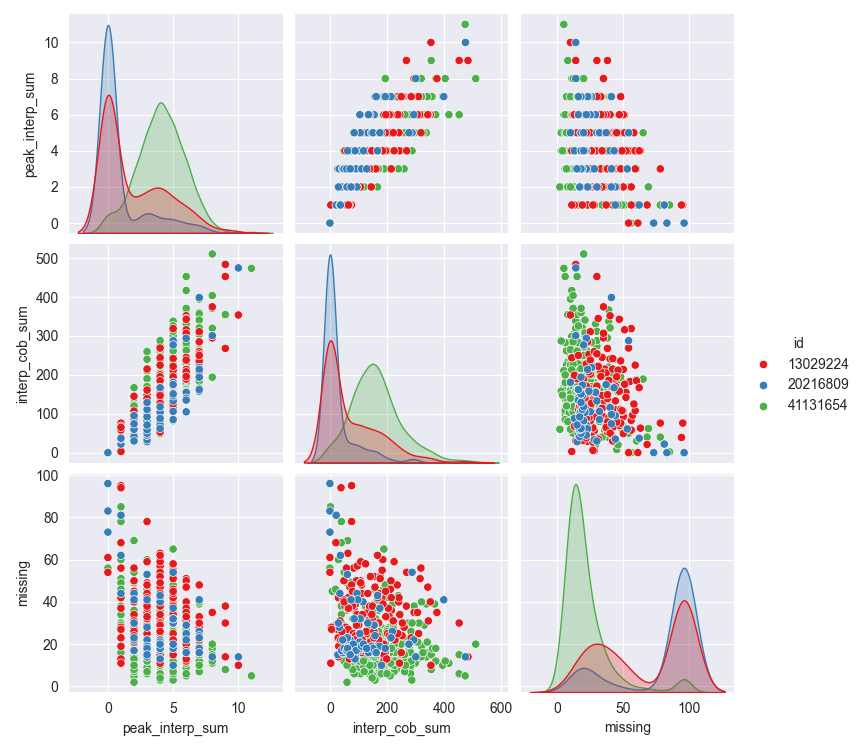

In [30]:
ids = [41131654,13029224,20216809]

compare_missing = pd.DataFrame()

df_batch = pre_process_batch(ids, df)
for id in ids:
    df_cob, df_agg_by_day = remove_zero_peak_days(df_batch.loc[id], id)
    compare_missing = pd.concat([compare_missing, df_agg_by_day])

sns.pairplot(compare_missing[['peak_interp_sum','interp_cob_sum','missing']].reset_index(), kind='scatter', hue='id', diag_kind='kde', palette='Set1')
plt.show()


The salient observations from this scatterplot matrix are:
* As anticipated, there appears to be a strong correlation between the COB intake and the number of peaks identified.
* There is some correlation between number of missing and the number of peaks/COB intake, which is anticipated, but appears perhaps more noisey and less strong than anticipated.
* Despite removing zero-value days, there number of missing values appears multi-modal for at least two of the individuals, with a less significant (though not insignificant) mode centering around near-complete missing values for a day (i.e. 96 intervals missing).

The last point is an interesting one, which we might want to carry out some analysis around. First, lets see what the prevalence of multi-modality is (using a dip test), but also them apply Siiverman's test to identify the possible number of modes (which we hypothesize to be two if at all). A first pass at this highlights - through an error when trying to execute the dip test - that there are certain records without any values. We need these removed as part of our prep, so this is being included into the pre_process_batch() function.

In [31]:
from scipy.stats import gaussian_kde
from sklearn.mixture import GaussianMixture
import diptest

# Set the batch of individuals to analyse and pre-process the data
ids = df['id'].drop_duplicates().values
df_batch = pre_process_batch(ids, df)

df_mode_analysis = pd.DataFrame()  # Initialize the DataFrame

# Loop through each individual, perform analysis and add to the DataFrame
for id in ids:
    idx = pd.IndexSlice
    df_indiv = df_batch.loc[idx[id, :], :]
    days_pre_proccessed = len(df_indiv['day'].drop_duplicates())
    df_all, df_all_by_day = remove_zero_peak_days(df_indiv)

    missing_vals = np.array(df_all_by_day['missing'].to_list())

    if len(missing_vals) <= 3:
        print(f'Not enough data for individual {id}')
        continue

    # Calculate the dip test
    dip, p_value = diptest.diptest(missing_vals)

    # Find peaks of the KDE for missing values
    kde = gaussian_kde(missing_vals)
    x_vals = np.linspace(missing_vals.min() - 2, missing_vals.max() + 2, 100)
    y_vals = kde(x_vals)
    peaks, properties = find_peaks(y_vals, height=0.01)
    peak_count = len(peaks)
    peak_means = x_vals[peaks]

    # Fit a Gaussian Mixture Model to the missing values
    gmm = GaussianMixture(n_components=2)
    gmm.fit(missing_vals.reshape(-1, 1))
    means = gmm.means_.flatten()
    weights = gmm.weights_.flatten()

    # Create a new DataFrame for the current ID
    new_data = pd.DataFrame({
        'id': [id],
        'count_all': [days_pre_proccessed],
        'count_missing': [len(missing_vals)],
        'dip': [dip],
        'p_value': [p_value],
        'peaks': [peak_count],
        'peak_1': [peak_means[0] if peak_count > 0 else np.nan],
        'peak_2': [peak_means[1] if peak_count > 1 else np.nan],
        'height_1': [properties['peak_heights'][0] if len(properties['peak_heights']) > 0 else np.nan],
        'height_2': [properties['peak_heights'][1] if len(properties['peak_heights']) > 1 else np.nan],
        'gmm_mean_1': [means[0] if len(means) > 0 else np.nan],
        'gmm_mean_2': [means[1] if len(means) > 1 else np.nan],
        'gmm_weight_1': [weights[0] if len(weights) > 0 else np.nan],
        'gmm_weight_2': [weights[1] if len(weights) > 1 else np.nan]
    })

    # Concatenate DataFrames
    df_mode_analysis = pd.concat([df_mode_analysis, new_data], ignore_index=True)


ModuleNotFoundError: No module named 'diptest'

In [43]:
print(f'Number of dip test p_values < 0.05: {len(df_mode_analysis[df_mode_analysis["p_value"] < 0.05])}')
print(f'Number of modal peaks > 1 for days with missing values: {len(df_mode_analysis[df_mode_analysis["peaks"] > 1])}')
print(f'Number of people with only one peak of missing values, greater than 90: {len(df_mode_analysis[(df_mode_analysis["peaks"] == 1) & (df_mode_analysis["peak_1"] > 90)])}')
display(df_mode_analysis[df_mode_analysis['peaks'] != 1])

Number of dip test p_values < 0.05: 49
Number of modal peaks > 1 for days with missing values: 15
Number of people with only one peak of missing values, greater than 90: 37


id  count_all  count_missing       dip   p_value  peaks     peak_1  \
6    16975609        252            252  0.026611  0.248286      2  56.636364   
9    13029224        325            325  0.097339  0.000000      2  29.818182   
15   86323903        284            284  0.119591  0.000000      2  30.363636   
16   43589707        497            497  0.084507  0.000000      2  29.232323   
19   64024750        156            156  0.134615  0.000000      2  51.636364   
31   15558575        173            173  0.190459  0.000000      2  18.202020   
34   37948668         75             75  0.136593  0.000000      2  22.989899   
40   14092221        772            772  0.149611  0.000000      2  15.838384   
47   40634871         90             90  0.112381  0.000000      2  48.222222   
49   28768536        179            179  0.155635  0.000000      2  14.717172   
59     221634        125            125  0.072000  0.000036      2  62.939394   
76   13484299        431            431  0.077548  0.000000      2  34.121212   
81   64406000        238            238  0.060924  0.000004      2  66.888889   
83   21946407        335            335  0.126251  0.000000      2  22.363636   
84   39986716          4              4  0.208861  0.047105      0        NaN   
100  79526193        443            443  0.181169  0.000000      2  13.000000   

        peak_2  height_1  height_2  gmm_mean_1  gmm_mean_2  gmm_weight_1  \
6    91.565657  0.012045  0.015253   96.000000   59.236277      0.158720   
9    96.181818  0.010692  0.020283   34.626584   96.000000      0.486154   
15   96.121212  0.013117  0.015699   34.416668   96.000000      0.591549   
16   96.141414  0.010264  0.025000   96.000000   35.127363      0.573441   
19   96.181818  0.022523  0.013074   49.973690   96.000000      0.730769   
31   95.979798  0.014830  0.011865   20.029126   96.000000      0.595376   
34   95.151515  0.010276  0.013248   96.000000   27.368422      0.493333   
40   96.020202  0.022185  0.012493   19.153420   96.000000      0.700777   
47   94.888889  0.015678  0.010520   48.720618   96.000000      0.755556   
49   96.040404  0.011992  0.013811   16.288922   95.775285      0.502794   
59   91.707071  0.024667  0.016982   93.098364   64.589220      0.257418   
76   95.181818  0.010267  0.022273   41.340968   96.000000      0.510441   
81   95.777778  0.036871  0.012198   86.850699   65.466310      0.255039   
83   95.090909  0.013257  0.016706   32.349001   96.000000      0.573135   
84         NaN       NaN       NaN   89.500000   12.000000      0.500000   
100  96.000000  0.015955  0.013816   96.000000   16.429119      0.410835   

     gmm_weight_2  
6        0.841280  
9        0.513846  
15       0.408451  
16       0.426559  
19       0.269231  
31       0.404624  
34       0.506667  
40       0.299223  
47       0.244444  
49       0.497206  
59       0.742582  
76       0.489559  
81       0.744961  
83       0.426865  
84       0.500000  
100      0.589165

The dip test has not been very reliable on our data and doesn't appear to be consistent with the other methods of highlighting a second peak of missing values. The other tests show that there is some consistency between the peak detection method and the Gaussian Mixture Model in detecting a second mode, particularly around 96 intervals missing. We have used the GMM as validation of the data coming from find_peaks(), which largely alignes GMM means to where the peaks are detected. Next, we look at one of the individual from this group that has two modes.

id  count_all  count_missing       dip   p_value  peaks     peak_1  \
6  16975609        252            252  0.026611  0.248286      2  56.636364   

      peak_2  height_1  height_2  gmm_mean_1  gmm_mean_2  gmm_weight_1  \
6  91.565657  0.012045  0.015253        96.0   59.236277       0.15872   

   gmm_weight_2  
6       0.84128

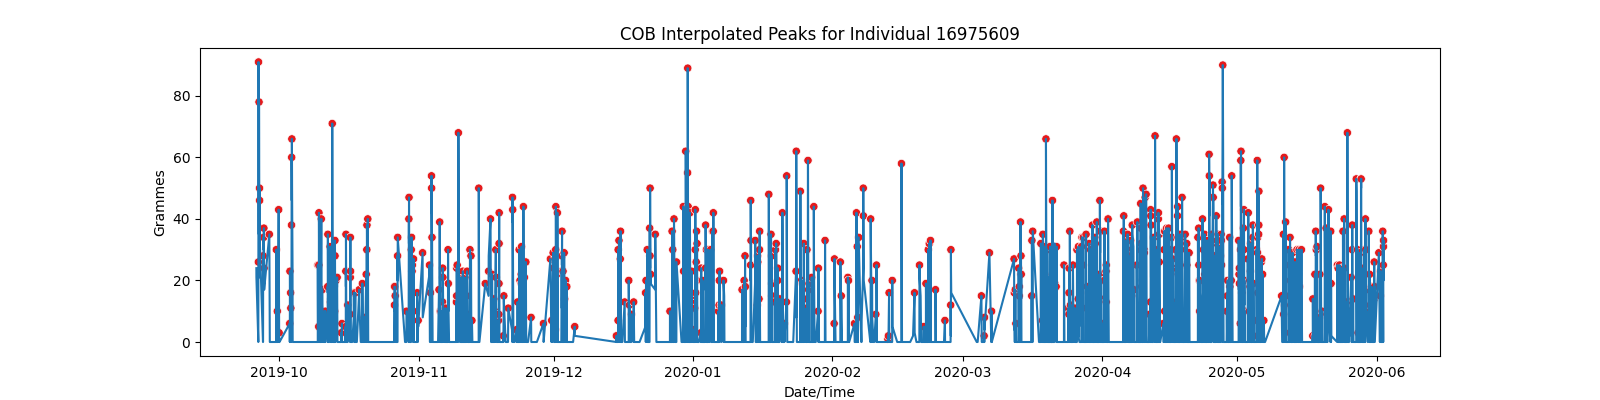

For ID 16975609: 74 days with no peaks removed, 252 remain.


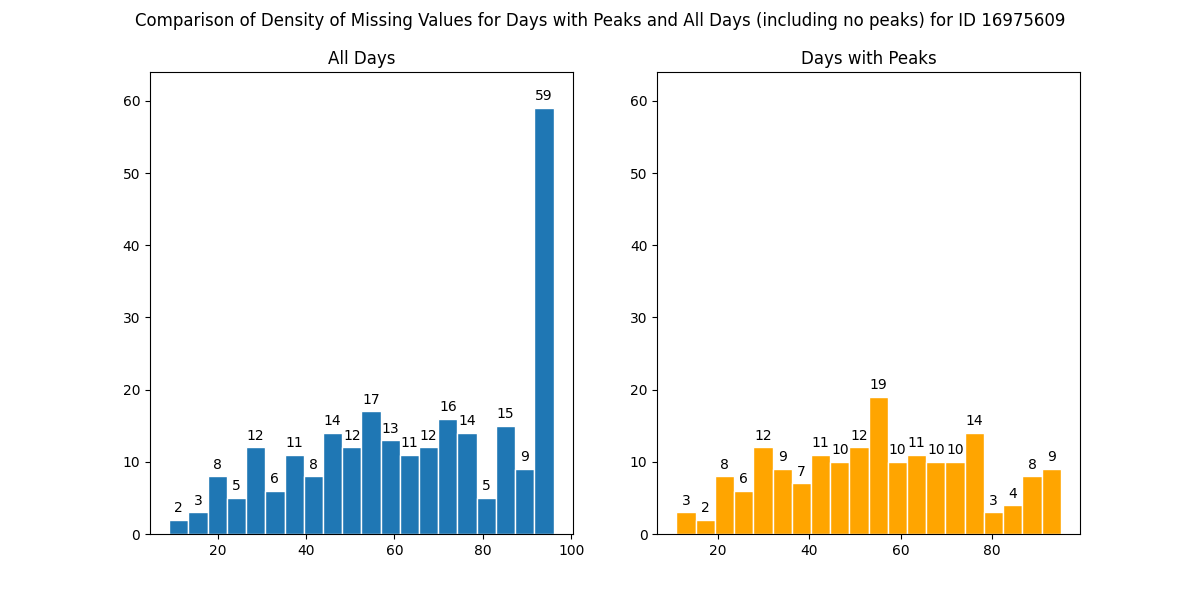

In [44]:

id = 16975609
display(df_mode_analysis[df_mode_analysis['id']==id])
df_cob, peak_indices = prep_cob_individual(id, df)
plot_peaks(df_cob, peak_indices, y='cob max', title=f'COB Interpolated Peaks for Individual {id}')
df_cob, df_cob_agg = remove_zero_peak_days(df_batch.loc[idx[id, :], :])

# Plot histograms comparing the missing values for individuals with different modal peaks
fig,ax = plt.subplots(figsize=(12,6), ncols=2)
counts1, bins1, patches1 = ax[0].hist(df_cob_agg['missing'], bins=20, edgecolor='white')
counts2, bins2, patches2 = ax[1].hist(df_cob_agg[df_cob_agg['removed']==0]['missing'], bins=20, color='orange', edgecolor='white')
max_count = max(max(counts1), max(counts2)) + 5
ax[0].set_ylim(0, max_count)
ax[1].set_ylim(0, max_count)
ax[0].set_title('All Days')
ax[1].set_title('Days with Peaks')
autolabel(patches1, ax[0])
autolabel(patches2, ax[1])
fig.suptitle(f'Comparison of Density of Missing Values for Days with Peaks and All Days (including no peaks) for ID {id}')
plt.show()

In [45]:
df_agg_rm_zeros = df_cob_agg[df_cob_agg['removed']==0].sort_values('missing', ascending=False)
df_agg_rm_zeros.head(5)

peak_interp_sum  interp_cob_sum  missing  removed
id       day                                                          
16975609 2019-11-15                1            19.0       95        0
         2020-03-06                1            29.0       95        0
         2019-11-28                1             6.0       93        0
         2020-05-10                1            15.0       93        0
         2020-02-26                1             7.0       93        0

There are still a significant number of days with high missing values coupled with very low maximum carbohydrate intake. This are quite suspect. Lets carry out a pairwise plot again of this data for an individual now that we have removed zero-peak days.

Before removing zero peak days: n=252


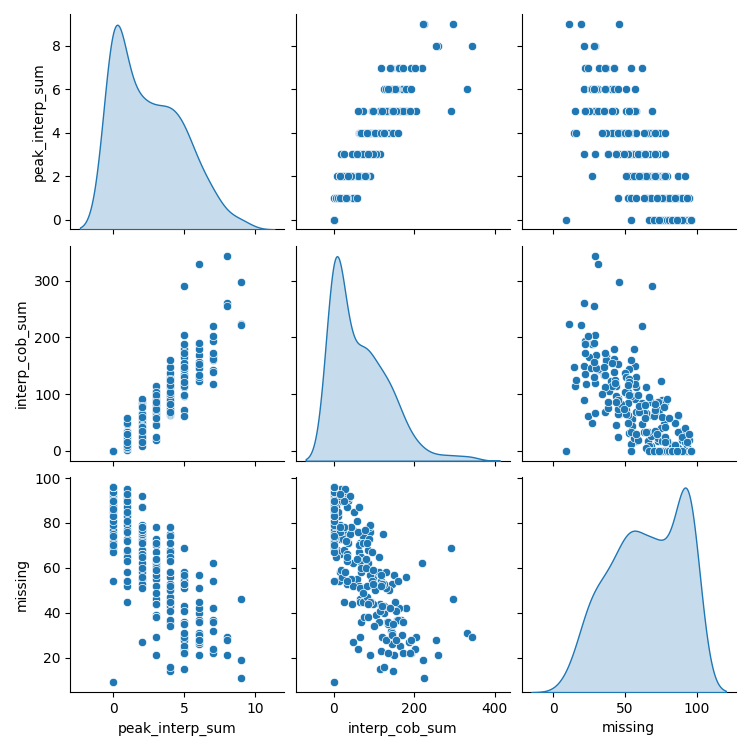

After removing zero peak days: n=178


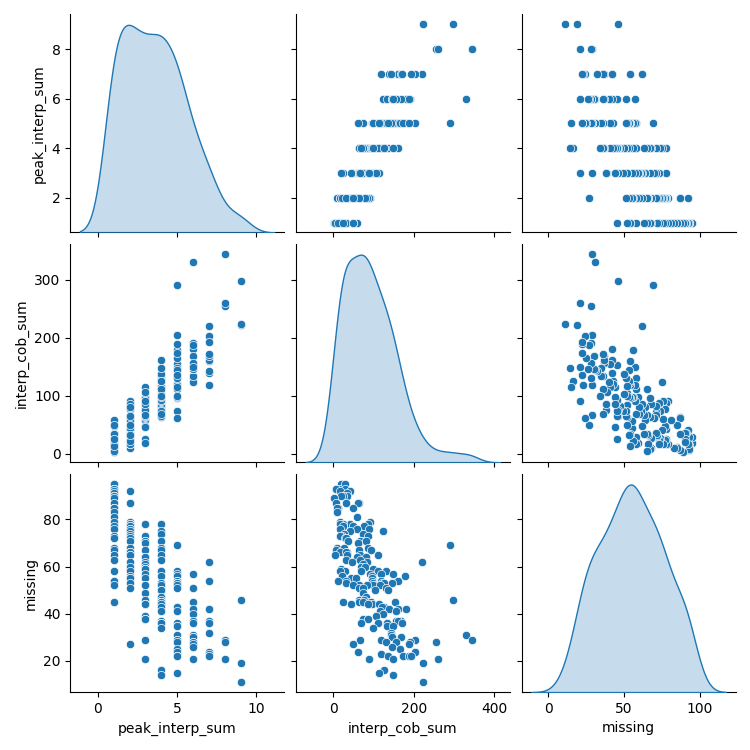

In [46]:
print(f'Before removing zero peak days: n={len(df_cob_agg)}')
sns.pairplot(df_cob_agg[['peak_interp_sum','interp_cob_sum','missing']], diag_kind='kde')
plt.show()

print(f'After removing zero peak days: n={len(df_agg_rm_zeros)}')
sns.pairplot(df_agg_rm_zeros[['peak_interp_sum','interp_cob_sum','missing']], diag_kind='kde')
plt.show()

We can see the impact that the number of missing values in a day is something that is having an impact on the total intake of carbohydrates. This is even clearer having removed zero-peak days. This points to the fact that days with missing values is having an impact on the recorded carbohydrate intake, in such as way that we know we are likely missing peaks as a result, which are key to our analysis. If we look at this correlation between 

In [47]:
import scipy.stats as st

correlation, p_value = st.pearsonr(df_agg_rm_zeros['interp_cob_sum'], df_agg_rm_zeros['missing'])

print(f"Pearson correlation: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

Pearson correlation: -0.664
P-value: 0.000


This demonstrates statistical significance that there is a negative correlation. If we plot this to see how it looks:

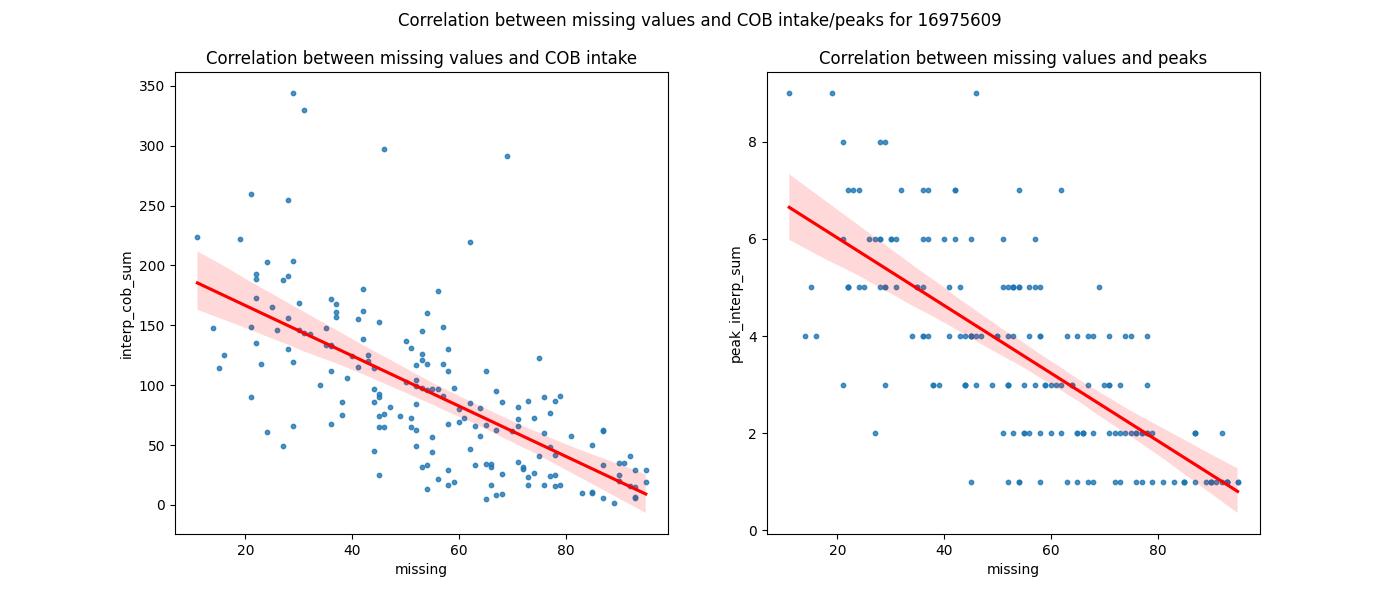

In [48]:
def plot_missing_vals(df: pd.DataFrame, id: int = None):
    """
    Plots the number of missing values in a day against the total COB intake for that day, and total peaks, showing the correlation.

    Parameters:
        df (pd.DataFrame): DataFrame containing COB data
    """
    fig,(ax1, ax2) = plt.subplots(figsize=(14,6), ncols=2)
    sns.regplot(data=df, x='missing', y='interp_cob_sum', ci=99, ax=ax1, scatter_kws={'s':10}, line_kws={'color':'red'})
    ax1.set_title(f'Correlation between missing values and COB intake')
    sns.regplot(data=df, x='missing', y='peak_interp_sum', ci=99, ax=ax2, scatter_kws={'s':10}, line_kws={'color':'red'})
    ax2.set_title(f'Correlation between missing values and peaks')
    fig.suptitle(f'Correlation between missing values and COB intake/peaks for {id if id else "all"}')  
    plt.show()

plot_missing_vals(df_agg_rm_zeros, id)
# fig,(ax1, ax2) = plt.subplots(figsize=(14,6), ncols=2)
# sns.regplot(data=df_agg_rm_zeros, x='missing', y='interp_cob_sum', ci=99, ax=ax1)
# ax1.set_title(f'Correlation between missing values and COB intake')
# sns.regplot(data=df_agg_rm_zeros, x='missing', y='peak_interp_sum', ci=99, ax=ax2)
# ax2.set_title(f'Correlation between missing values and peaks')
# fig.suptitle(f'Correlation between missing values and COB intake/peaks for individual {id}')
# plt.show()

This shows that almost half of the individuals have missing intervals for a day that are likely multimodal. This demonstrates that there is a phenomena in the data that we suspected and should somehow address. It would be useful to know what the means are for each of the separate modes in the distribution to see if there is a correlation. The hypothesis is that this might centre around the high end (96 intervals per day). We can use our find_peaks() function or Gaussian Mixture Models. We'll compare the output of both.

Moving from a single individual to the whole dataset (generalised over all IDs):

For batch of 114 individuals: 22700 days with no peaks removed, 7767 remain.


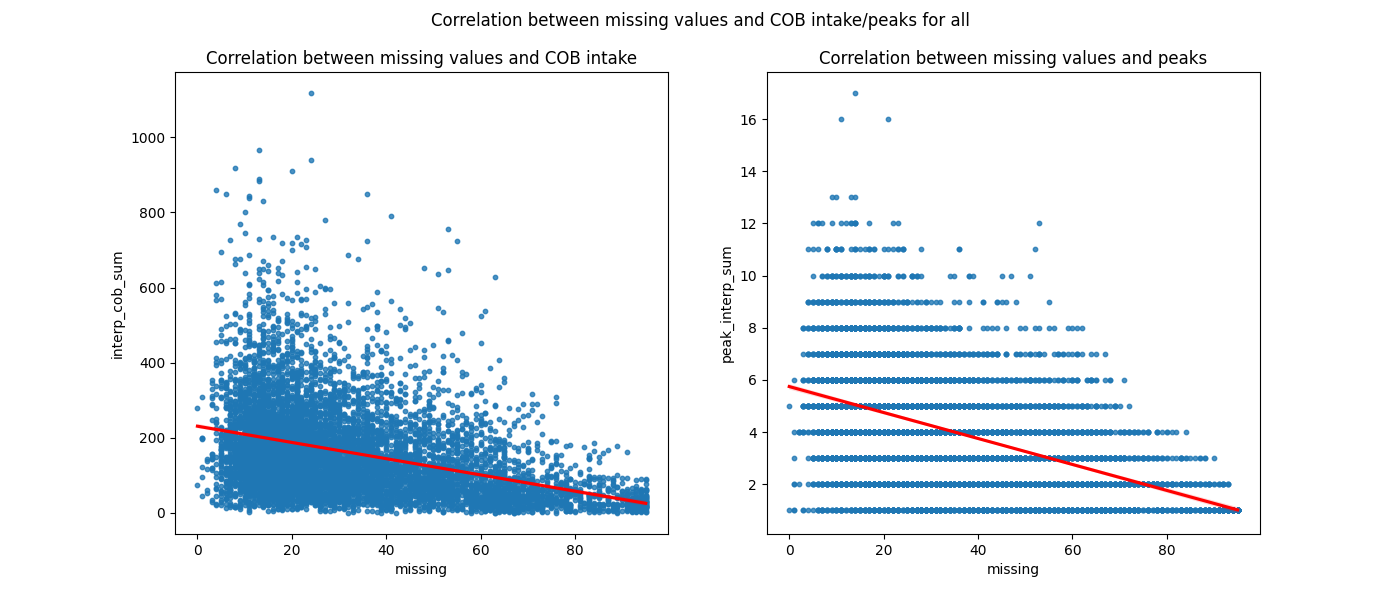

In [ ]:
# Uses df_batch from previous cell that contains all individuals
# TAKES 5m 46s TO RUN - AVOID
df_all, df_all_by_day = remove_zero_peak_days(df_batch)
plot_missing_vals(df_all_by_day[df_all_by_day['removed']==0])




## Tuning the parameters for our find_peaks() algorithm
Using the analysis tools we've built, we want to tune the height and distance parameters for find_peaks to most accurately identify which are substantive meal intakes. Although there is no way of telling or infering via the one variable of COB what the intent has been behind a historic intake of carbohydrates, we know from previous texts (Cryer et al, 2009, Wiethop, Cryer, 1993) that an oral intake of glucose between 10-20g is a common recommended dose. Evidence shows that the glycaemic response may be transient and should be followed by a more substantial snack/meal within 2 hours.

Our time series COB data has well defined peaks and is distinctly lacking in noise. Therefore we look to set two parameters: height and distance. The height parameter will deterime the absolute number of grams of carbohydrate that someone has ingested allowing us to set a threshold around the amount of carbohydrates that we determine significant enough to consider in analysis. The distance parameter will help determine how close we allow peaks representing intake to be before we consider it as part of the same meal intake. Our find_peaks considers one step (at hour sample rate) as one hour. It does not accept floats, only integers. 

Therefore, our analysis will be based on peaks of carbohydrates around this range, thus suggesting our height parameter. Then we will consider our distance to be anything around 1 hour of this, (equating to a distance of 4 based on 15 minute samples). We will look at how this compares over ranges in these parameters.
$$\{sk  |  k \in [a..b]\}$$ 
(maths range notation - https://math.stackexchange.com/questions/2056510/what-is-the-mathematical-symbol-for-range)
$$\{\frac{1}{2}k  |  k \in [20..30]\}$$
h=15 +/- 5, and d=4 +/- 4 , to see the number of peaks this determines for each individual. This will use the following method:
1. Define a matrix of d and h value permutations
2. Process each individual with each permutation and build matrix of results
3. Aggregate the number of peaks per day by permutation, review the general distribution and investigate anomolies
4. Apply appropriate strategies to deal with anolomies
5. Select 

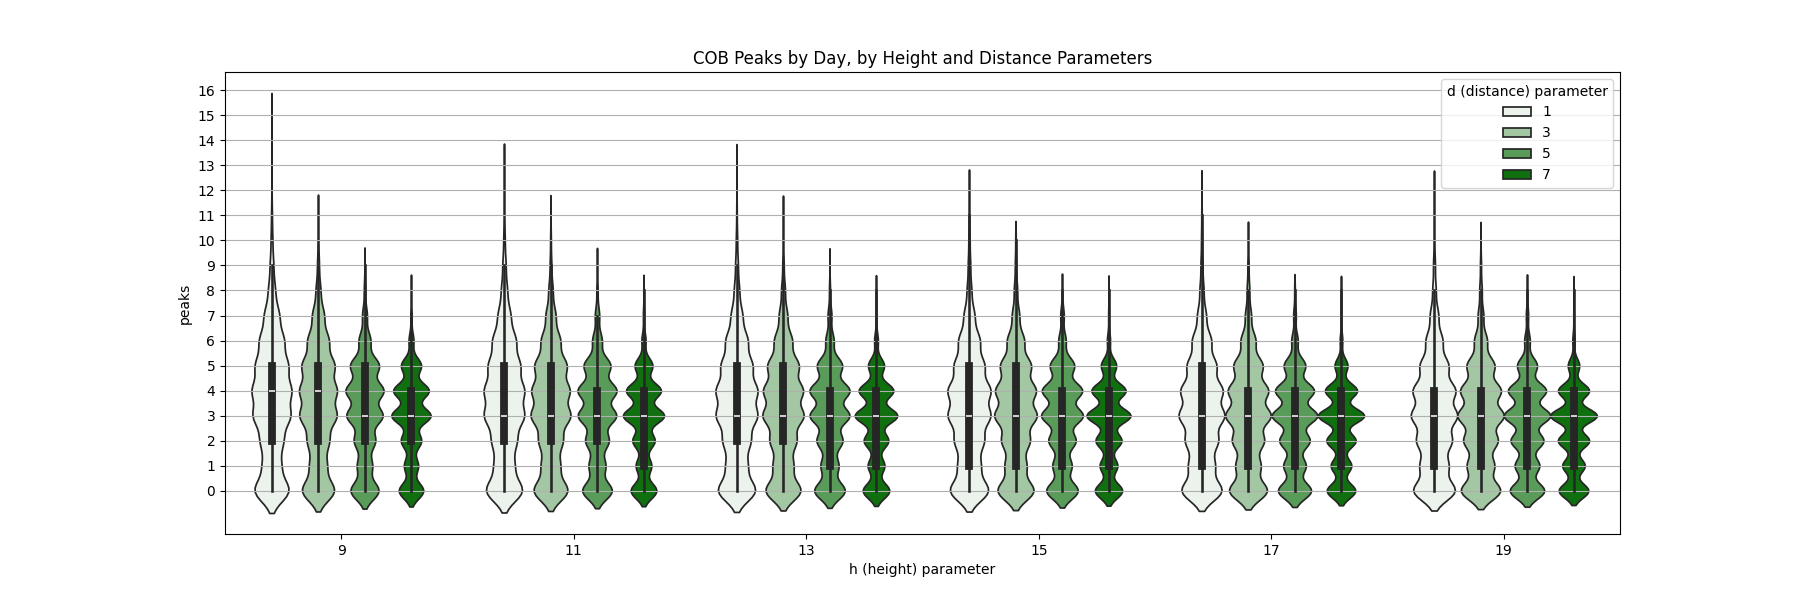

In [50]:
# Create a dataframe of all possible combinations of height and distance
heights = np.arange(9,21,2)
distances = np.arange(1,8,2)
param_arrays = np.meshgrid(heights, distances)
data = {
    'h': param_arrays[0].flatten(),
    'd': param_arrays[1].flatten()
}
df_params = pd.DataFrame(data=data)

# # Create a dataframe to store the results of the experiment and produce the data
# df_params_exp = pd.DataFrame()

# for id in df_cob_interp['id'].drop_duplicates():
#     cob_indiv = df_cob_interp[df_cob_interp['id']==id].copy()
#     cob_indiv = cob_indiv.reset_index(names='datetime')
#     for i, r in df_params.iterrows():
#         peak_indices, _ = cob_peaks(ser=cob_indiv['cob max'], h=r['h'], d=r['d'])
#         cob_indiv['peaks'] = 0
#         cob_indiv.loc[peak_indices, 'peaks'] = 1
#         cob_indiv = cob_indiv.assign(id=id, h=r['h'], d=r['d'])
#         df_params_exp = pd.concat([df_params_exp, cob_indiv])

# df_params_exp.reset_index(drop=True, inplace=True)

# # Save the results of the experiment to a parquet file given the experiment is time-consuming
# df_params_exp.to_parquet(f_path + 'cob_peaks_exp.parquet')

df_params_exp = pd.read_parquet(f_path + 'cob_peaks_exp.parquet')

peaks_by_day = (df_params_exp[['id','day','h','d','peaks']]
                .groupby(['id','day','h','d'])
                .agg('sum'))

d_palette = sns.light_palette("green", as_cmap=True)
h_palette = sns.light_palette("blue", as_cmap=True)
def plot_peaks_by_day(df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(18,6))
    sns.violinplot(data=df, x='h', y='peaks', hue='d', ax=ax, palette=d_palette)
    plt.title('COB Peaks by Day, by Height and Distance Parameters')
    plt.grid(axis='y')
    plt.xlabel('h (height) parameter')
    plt.yticks(range(0,17,1))
    plt.legend(title='d (distance) parameter')
    plt.show()

plot_peaks_by_day(peaks_by_day)

#### Zero-Peak Days
The plot shows that throughout the data there is a prevalence of days with zero meals intake. 24-hour fasting among people with T1D is highly unlikely yet it might be that some days for certain people, peaks may be removed the higher the parameter threshold, resulting in zero for that day. To discount any zero-peak days that might be due to data inconsistencies - such as missing data - we'll remove the instances where peaks do not exist for the parameters set at the lowest threshold of h=9, d=1. First, lets look at the number of zero-peak days in the analysis, relative to the different parameters.

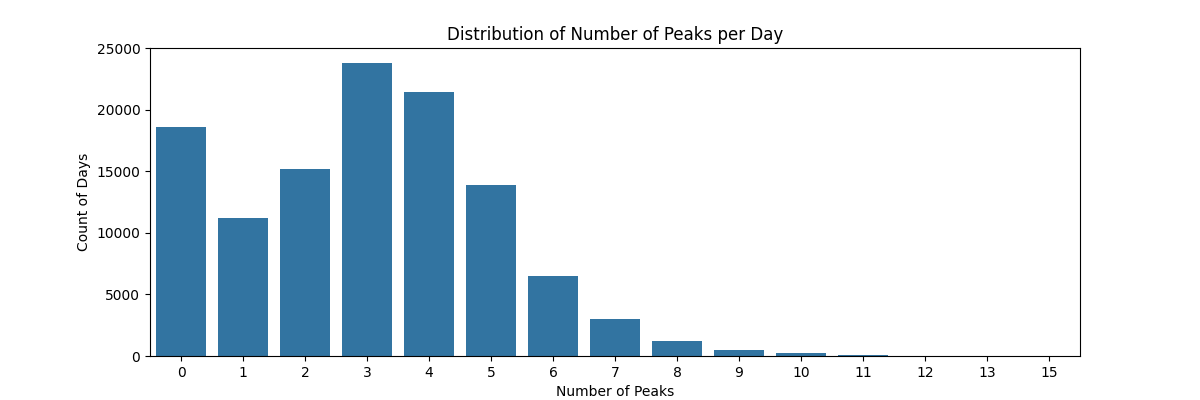

In [51]:
peaks_count = peaks_by_day.groupby(['peaks'])['peaks'].count()
plt.figure(figsize=(12,4))
sns.barplot(x=peaks_count.index, y=peaks_count.values)
plt.xlabel('Number of Peaks')
plt.ylabel('Count of Days')
plt.title('Distribution of Number of Peaks per Day')
plt.show()


Number of days with no peaks at h=9 and d=1: 735
Length of original dataset: 115680
Length of dataset with zero-peak days removed: 98040


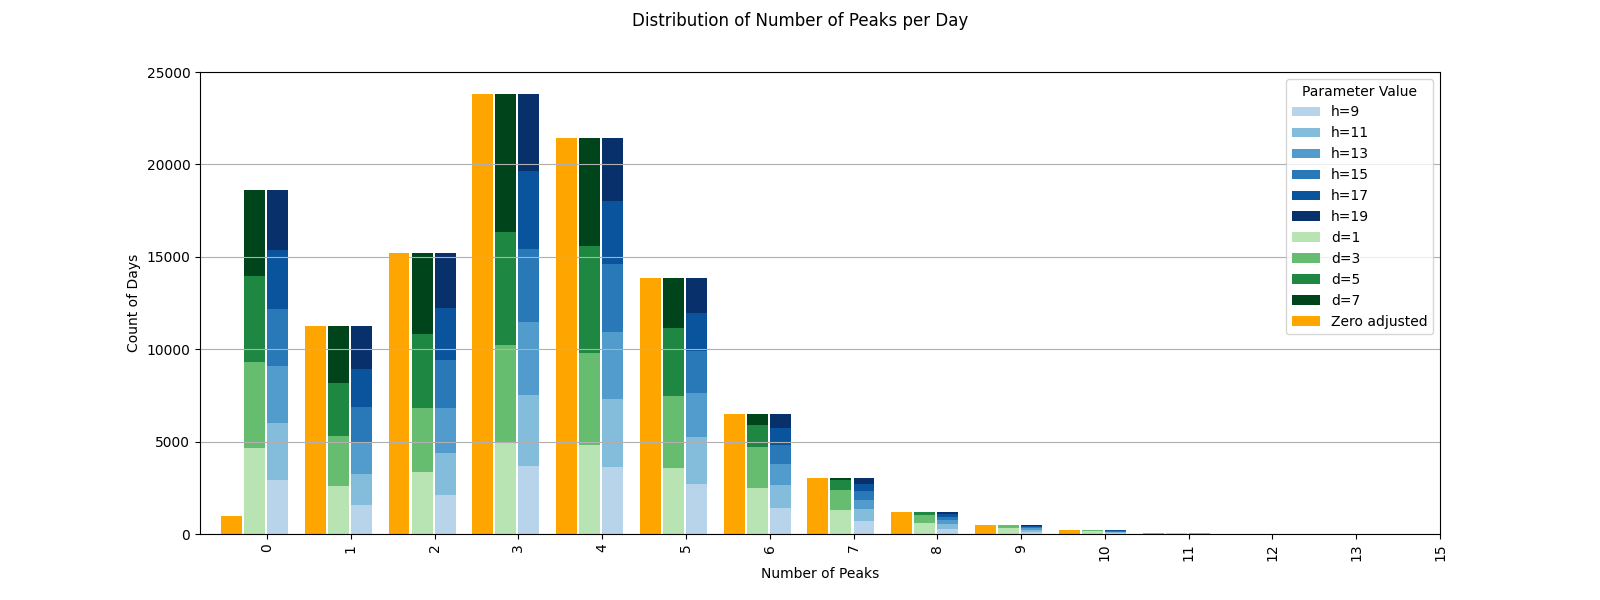

In [52]:
peaks_by_day_reset = peaks_by_day.reset_index().set_index(['id','day'])

blues = plt.get_cmap('Blues')
h_colours = LinearSegmentedColormap.from_list('custom_blues', blues(np.linspace(0.3, 1, 256)))
peaks_by_h = (peaks_by_day_reset
              .groupby(['h','peaks'])
              .agg(count=('h','count'))
              .reset_index()
              .pivot(index='peaks', columns='h', values='count')
              .fillna(0))

greens = plt.get_cmap('Greens')
d_colours = LinearSegmentedColormap.from_list('custom_greens', greens(np.linspace(0.3, 1, 256)))
peaks_by_d = (peaks_by_day_reset
              .groupby(['d','peaks'])
              .agg(count=('d','count'))
              .reset_index()
              .pivot(index='peaks', columns='d', values='count')
              .fillna(0))

zero_peak_days = peaks_by_day_reset[(peaks_by_day_reset['peaks']==0) 
                   & (peaks_by_day_reset['h']==9) 
                   & (peaks_by_day_reset['d']==1)]
print(f'Number of days with no peaks at h=9 and d=1: {len(zero_peak_days)}')

peaks_zero_adjusted = peaks_by_day_reset.drop(index=zero_peak_days.index)
print(f'Length of original dataset: {len(peaks_by_day_reset)}')
print(f'Length of dataset with zero-peak days removed: {len(peaks_zero_adjusted)}')
zero_adjusted_grouped = peaks_zero_adjusted.groupby(['peaks'])['peaks'].count()

# Plotting the distribution of peaks by height and distance parameters, against that of zero-peak days adjusted for h=9 and d=1
fig, ax = plt.subplots(figsize=(16, 6))
bar_width = 0.25
bars_h = peaks_by_h.plot(kind='bar', stacked=True, colormap=h_colours, position=0, width=bar_width, ax=ax)
bars_d = peaks_by_d.plot(kind='bar', stacked=True, colormap=d_colours, position=1.1, width=bar_width, ax=ax)
bars_zero = zero_adjusted_grouped.plot(kind='bar', stacked=True, position=2.2, width=bar_width, color='orange', ax=ax)
ax.set_xlabel('Number of Peaks')
ax.grid(axis='y')
ax.set_ylabel('Count of Days')
legend_labels = ['h=9','h=11','h=13','h=15','h=17','h=19', 'd=1','d=3','d=5','d=7','Zero adjusted']
ax.legend(title='Parameter Value', loc='upper right', labels=legend_labels)
fig.suptitle('Distribution of Number of Peaks per Day')
plt.show()

The orange bars show the distribution having made the adjustment for zero-peak days. This further highlights a potential anomoly whereby the prevalence of 1-peak days may not reflect the underlying distribution. We would expect few instances of days in which carbohydrate intake exceeding 9g to only happen once. However, it is difficult to understand the underlying cause without better understanding the data capture method and behaviours. It may be that we need to impute data to reflect the distribution, but before we make this decision, lets focus on selecting the parameters and producing our final dataset of peaks-by-day to work with. First, we repeat our prior analysis with the zero-peak adjusted data.

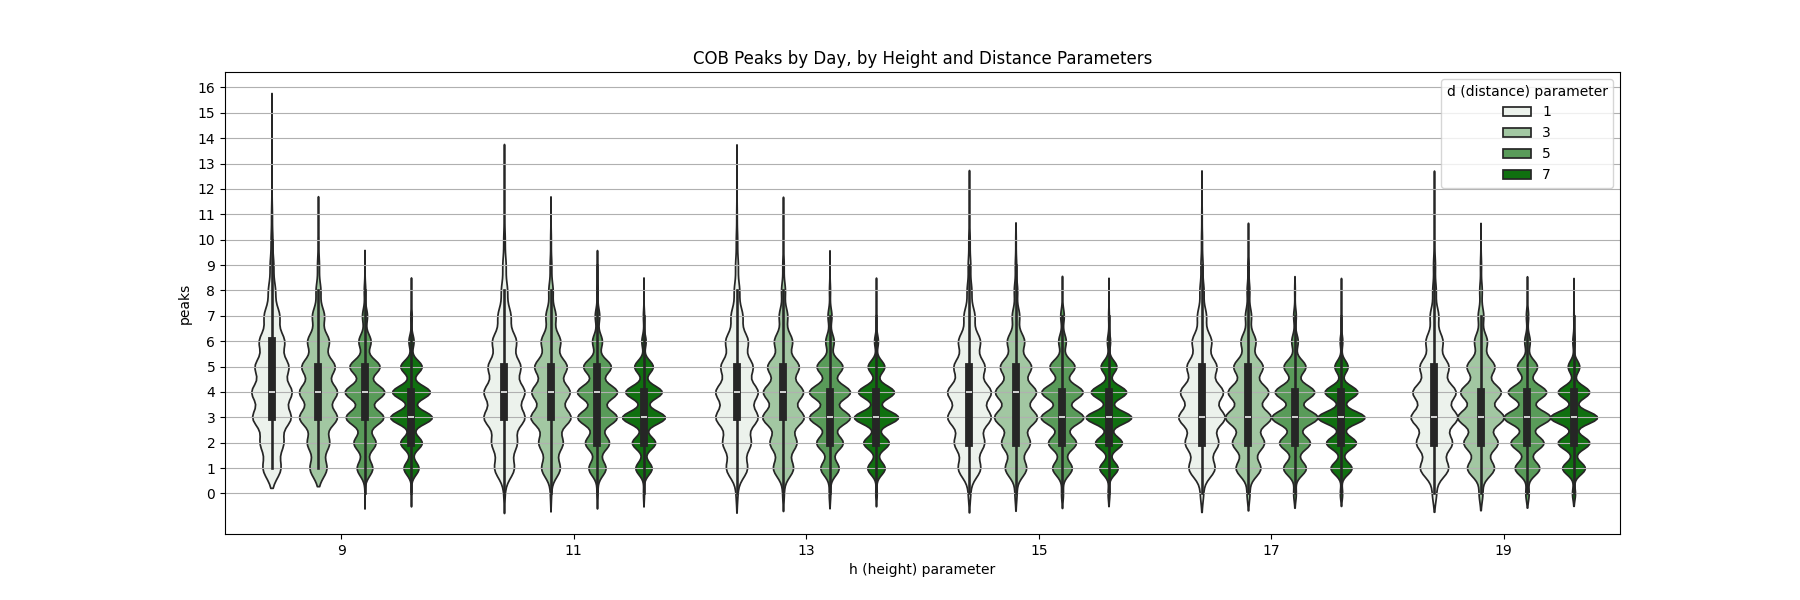

peaks                         
          mean       std min max    sum
h  d                                   
9  1  4.269523  2.058656   1  15  17441
   3  4.076867  1.883083   1  11  16654
   5  3.677111  1.570036   0   9  15021
   7  3.347124  1.347884   0   8  13673
11 1  4.093513  2.035091   0  13  16722
   3  3.909180  1.863045   0  11  15969
   5  3.532191  1.558445   0   9  14429
   7  3.227173  1.347830   0   8  13183
13 1  3.961567  1.996506   0  13  16183
   3  3.783109  1.826178   0  11  15454
   5  3.427907  1.535574   0   9  14003
   7  3.139290  1.331983   0   8  12824
15 1  3.863647  1.965985   0  12  15783
   3  3.688617  1.797125   0  10  15068
   5  3.347368  1.511309   0   8  13674
   7  3.073929  1.314955   0   8  12557
17 1  3.668788  1.925070   0  12  14987
   3  3.502570  1.758930   0  10  14308
   5  3.184578  1.483572   0   8  13009
   7  2.934884  1.298183   0   8  11989
19 1  3.546144  1.904847   0  12  14486
   3  3.386781  1.742121   0  10  13835
   5  3.081273  1.472488   0   8  12587
   7  2.846512  1.293278   0   8  11628

In [53]:
plot_peaks_by_day(peaks_zero_adjusted)

peaks_zero_adjusted_summary = (peaks_zero_adjusted
 .groupby(['h','d'])
 .agg({'peaks':['mean','std','min','max','sum']}))

display(peaks_zero_adjusted_summary)

Based on visual inspection, the initial assumptions around the best choice for distance appears somewhat validated by the data. At a distance of under 5 we see a significant spread of peaks, with ranges becoming more within the expected range as we exceed 4. The deviation becomes more limited but the mean is dropping too close to (and below) 3 peak per day at h > 13. We will continue for now with d=5 and look more closely at height. 

In [54]:
peaks_at_d5 = peaks_zero_adjusted[peaks_zero_adjusted['d']==5]
display(peaks_at_d5.head())

h  d  peaks
id      day                     
4762925 2017-10-13   9  5      1
        2017-10-13  11  5      1
        2017-10-13  13  5      1
        2017-10-13  15  5      1
        2017-10-13  17  5      1

peaks                         
          mean       std min max    sum
h  d                                   
9  5  3.677111  1.570036   0   9  15021
11 5  3.532191  1.558445   0   9  14429
13 5  3.427907  1.535574   0   9  14003
15 5  3.347368  1.511309   0   8  13674
17 5  3.184578  1.483572   0   8  13009
19 5  3.081273  1.472488   0   8  12587

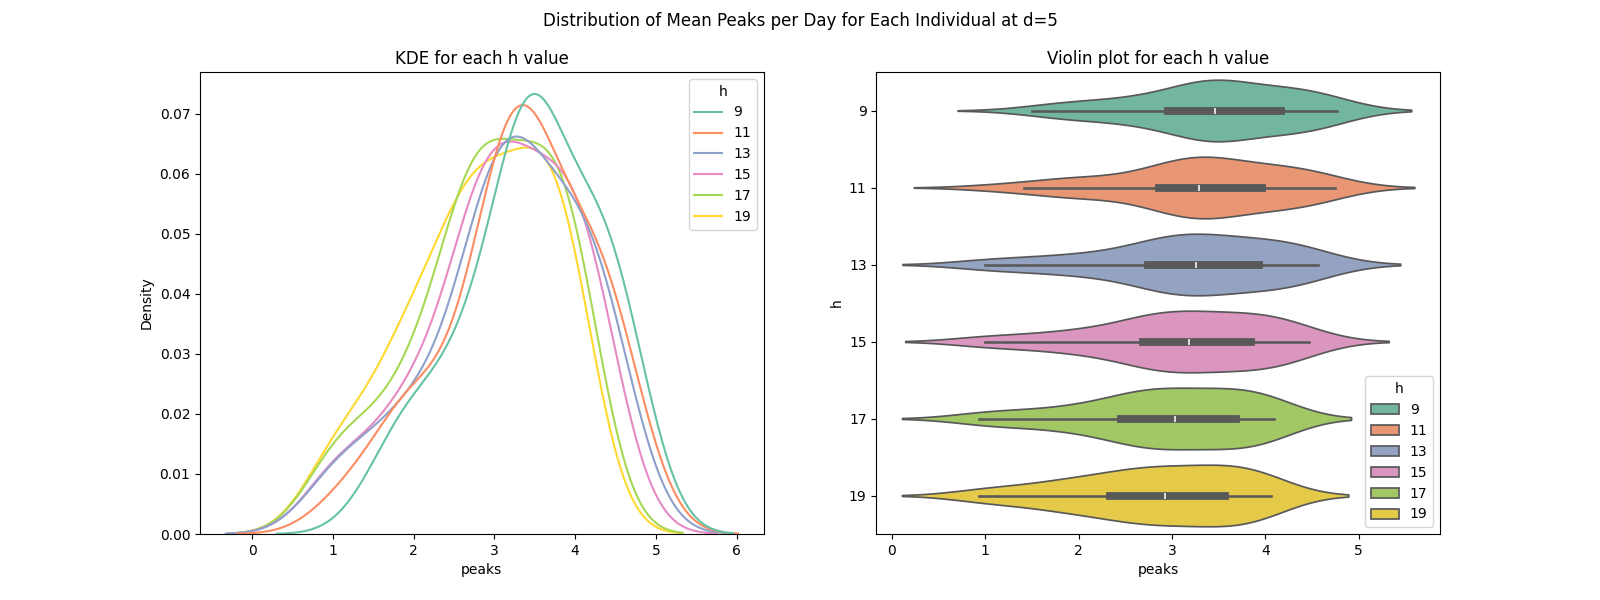

In [55]:
h_means = peaks_at_d5.groupby(['id','h']).agg({'peaks':'mean'}).reset_index().set_index('id')

display(peaks_zero_adjusted_summary.loc[(slice(None), 5), :])

fig, ax = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
sns.kdeplot(data=h_means, x='peaks', hue='h', palette='Set2', ax=ax[0])
ax[0].set_title('KDE for each h value')
ax[1].set_title('Violin plot for each h value')
sns.violinplot(data=h_means, x='peaks', y='h', hue='h', palette='Set2', ax=ax[1], orient='h')
fig.suptitle('Distribution of Mean Peaks per Day for Each Individual at d=5')
plt.show()

There is little difference between the outcomes of each height parameter value that we will continue with h=15. There will be an opportunity to test the accuracy of a model furter on with the chosen parameters for accuracy.

### High Peak-Count Outliers

Though there are days in which an excess of 6 peaks are counted, we mustn't discount these as they may be valid. It is less possible to challenge the circumstances of outliers amongst these, though it might be worth looking at some of the extreme examples to see if there are patterns or salient issues that appear. We'll do so using our sample of COB on days with high peaks at our chosen (h,d).

In [56]:
peaks_d5_h15 = peaks_zero_adjusted[(peaks_zero_adjusted['h']==15) & (peaks_zero_adjusted['d']==5)].drop(columns=['h','d'])
high_max_people = peaks_d5_h15.groupby(['id']).agg({'peaks':['mean', 'count', 'min','max']}).sort_values(('peaks','max'), ascending=False).head()
display(high_max_people)

peaks              
              mean count min max
id                              
13783771  4.226804    97   1   8
17161370  3.623288   146   0   8
14092221  3.996255   534   1   8
32997134  4.246154    65   0   8
74077367  3.986264   364   0   8

In [57]:
def filter_date_range(df: pd.DataFrame, from_date: str, to_date: str):
    df['day'] = df.index.strftime('%Y-%m-%d')
    df_filtered = df[(df['day'] >= from_date) & (df['day'] <= to_date)]
    return df_filtered.drop(columns='day')

subject = 13783771
cob_indiv = cob_individual(df, subject)
peak_indices,properties = cob_peaks(cob_indiv['cob max'], h=15, d=5)

indiv_high_peaks_per_day = (peaks_zero_adjusted.loc[subject]
                            .query('h==15 & d==5')
                            .sort_values('peaks', ascending=False)
                            .head(5))
print(f'The following are the max peaks for individual {subject}')
display(indiv_high_peaks_per_day)

from_date = indiv_high_peaks_per_day.index[0].strftime('%Y-%m-%d')
print(from_date)
to_date = from_date
cob_indiv_filtered = filter_date_range(cob_indiv, from_date, to_date)
cob_indiv_filtered

The following are the max peaks for individual 13783771


h  d  peaks
day                     
2017-04-27  15  5      8
2017-05-01  15  5      8
2017-04-22  15  5      8
2017-03-04  15  5      7
2017-04-29  15  5      7

2017-04-27


AttributeError: 'MultiIndex' object has no attribute 'strftime'